# Modelo con calibracion de resultados

## Librerias necesarias 

In [70]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
# from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
# from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Binarizer

from sklearn.ensemble import RandomTreesEmbedding
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_classification
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
import os


### Es necesario un historico de datos, es muy dificil predecir en comportamiento de grupos de personas sin datos historicos, un par de años por lo menos
Tambien estaria bien tener datos de:
- Tipo de cliente / tipo de poliza 
- SI es prima unica o no 
- Variables que sean mas sobre el cliente

In [71]:
os.getcwd()

'c:\\Users\\mbuendiarascon\\Documents\\Modelos comportamentales\\python'

In [101]:
ruta = r'C:\Users\mbuendiarascon\Documents\Modelos comportamentales\datos\rescates_2022.xlsx'
cartera = pd.read_excel(ruta, sheet_name='Rescates' )

In [73]:
cartera.head()

,POL,EDAD,SEX,DUR_AÑOS,ANTIGÜEDAD,Año_VTO,MESES HASTA PROJ,RESTO_MESES HASTA VTO,PU,INT_GAR,...,INT_MERCADO,DIFF,RESCATE,ENTRY_YEAR,AGE_AT_ENTRY,POL_YEAR,PREM_PAYBL_M,ENTRY_MONTH,G_FUND_PC,ADD_TERM_M
0,445050048961226N,59,1,25,20,2027,238,5,900.0,0.03,...,0.032,0.002,SIN_RESCATE,2002,39,2002,300,9,0.010920,10
1,445050048953139K,62,0,22,20,2024,238,2,1560.0,0.03,...,0.032,0.002,SIN_RESCATE,2002,42,2002,264,9,0.012008,11
2,44505004802368J,61,0,24,20,2026,238,4,1440.0,0.03,...,0.032,0.002,SIN_RESCATE,2002,41,2002,288,9,0.011442,6
3,4450500413107960F,59,0,25,20,2027,238,5,750.0,0.03,...,0.032,0.002,SIN_RESCATE,2002,39,2002,300,9,0.011045,9
4,4450500411806630V,55,0,30,20,2032,238,10,630.0,0.03,...,0.032,0.002,SIN_RESCATE,2002,35,2002,360,9,0.009895,4


In [74]:
cartera.dtypes

POL                       object
EDAD                       int64
SEX                        int64
DUR_AÑOS                   int64
ANTIGÜEDAD                 int64
Año_VTO                    int64
MESES HASTA PROJ           int64
RESTO_MESES HASTA VTO      int64
PU                       float64
INT_GAR                  float64
PM (FONDO)               float64
INT_MERCADO              float64
DIFF                     float64
RESCATE                   object
ENTRY_YEAR                 int64
AGE_AT_ENTRY               int64
POL_YEAR                   int64
PREM_PAYBL_M               int64
ENTRY_MONTH                int64
G_FUND_PC                float64
ADD_TERM_M                 int64
dtype: object

In [75]:
cartera.columns

Index(['POL', 'EDAD', 'SEX', 'DUR_AÑOS', 'ANTIGÜEDAD', 'Año_VTO',
       'MESES HASTA PROJ', 'RESTO_MESES HASTA VTO', 'PU', 'INT_GAR',
       'PM (FONDO)', 'INT_MERCADO', 'DIFF', 'RESCATE', 'ENTRY_YEAR',
       'AGE_AT_ENTRY', 'POL_YEAR', 'PREM_PAYBL_M', 'ENTRY_MONTH', 'G_FUND_PC',
       'ADD_TERM_M'],
      dtype='object')

In [76]:
# lets see duplicates
cartera.duplicated().sum() # this will give us the number of duplicates in the data set

0

In [77]:
cartera['RESCATE'].value_counts()

RESCATE
SIN_RESCATE    89581
RESCATE          879
Name: count, dtype: int64

In [102]:

def sanitize_column_names(df):

    # Replace spaces with underscores
    df.columns = df.columns.str.replace(' ', '_', regex=False)
    # Replace parentheses with nothing
    df.columns = df.columns.str.replace('ï»¿', '', regex=True)
    df.columns = df.columns.str.replace('ñ', 'n', regex=True)
    df.columns = df.columns.str.replace('ü', 'U', regex=True)
    df.columns = df.columns.str.replace('Ñ', 'N', regex=True)
    # df.columns = df.columns.str.replace('.', '', regex=True)
 
    
    return df

sanitize_column_names(cartera)
cartera.head()


,POL,EDAD,SEX,DUR_ANOS,ANTIGÜEDAD,Ano_VTO,MESES_HASTA_PROJ,RESTO_MESES_HASTA_VTO,PU,INT_GAR,...,INT_MERCADO,DIFF,RESCATE,ENTRY_YEAR,AGE_AT_ENTRY,POL_YEAR,PREM_PAYBL_M,ENTRY_MONTH,G_FUND_PC,ADD_TERM_M
0,445050048961226N,59,1,25,20,2027,238,5,900.0,0.03,...,0.032,0.9375,SIN_RESCATE,2002,39,2002,300,9,0.010920,10
1,445050048953139K,62,0,22,20,2024,238,2,1560.0,0.03,...,0.032,0.9375,SIN_RESCATE,2002,42,2002,264,9,0.012008,11
2,44505004802368J,61,0,24,20,2026,238,4,1440.0,0.03,...,0.032,0.9375,SIN_RESCATE,2002,41,2002,288,9,0.011442,6
3,4450500413107960F,59,0,25,20,2027,238,5,750.0,0.03,...,0.032,0.9375,SIN_RESCATE,2002,39,2002,300,9,0.011045,9
4,4450500411806630V,55,0,30,20,2032,238,10,630.0,0.03,...,0.032,0.9375,SIN_RESCATE,2002,35,2002,360,9,0.009895,4


In [79]:
cartera = cartera.drop('INT_MERCADO', axis=1)

### Adjuste de la frecuencia de la poliza 

In [80]:
def map_add_term_to_prem_freq(add_term):
    if add_term == 12:
        return 'Mensual'
    elif add_term == 4:
        return 'Cuatrimestral'
    elif add_term == 2:
        return 'Bimestral'
    elif add_term == 3:
        return 'Trimestral'
    elif add_term == 6:
        return 'Semi-Annually'
    elif add_term == 1:
        return 'Annually'
    else:
        return 'Other'  

cartera['PREM_FREQ'] = cartera['ADD_TERM_M'].apply(map_add_term_to_prem_freq)


print(cartera[['ADD_TERM_M', 'PREM_FREQ']].head())

   ADD_TERM_M      PREM_FREQ
0          10          Other
1          11          Other
2           6  Semi-Annually
3           9          Other
4           4  Cuatrimestral


In [81]:
cartera['ADD_TERM_M'].value_counts()

ADD_TERM_M
6     8945
11    8522
5     8026
7     7652
2     7555
4     7522
10    7415
3     7202
9     7086
8     6975
1     6497
0     4284
12    2779
Name: count, dtype: int64

In [82]:
cartera['PREM_FREQ'].value_counts()

PREM_FREQ
Other            49960
Semi-Annually     8945
Bimestral         7555
Cuatrimestral     7522
Trimestral        7202
Annually          6497
Mensual           2779
Name: count, dtype: int64

In [83]:
cartera.drop(columns=['ADD_TERM_M'], inplace=True)

##### Ajustar para que las variables de interes garantizado y diferencial tengo solo 4 decimales

In [84]:
cartera['INT_GAR'] = cartera['INT_GAR'].round(4)
cartera['DIFF'] = cartera['DIFF'].round(4)

# Mostrar las primeras filas del DataFrame para verificar
print(cartera[['INT_GAR', 'DIFF']].head())

   INT_GAR   DIFF
0     0.03  0.002
1     0.03  0.002
2     0.03  0.002
3     0.03  0.002
4     0.03  0.002


# Correlaciones entre variables 

In [85]:
!pip install  


Defaulting to user installation because normal site-packages is not writeable


ERROR: You must give at least one requirement to install (see "pip help install")


In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

In [87]:
# import ace_tools
rescued_policies = cartera[cartera['RESCATE'] == 'RESCATE']

# Calcular el tiempo de la póliza en años hasta el rescate
rescued_policies['TIME_TO_RESCUE_YEARS'] = 2022 - rescued_policies['ENTRY_YEAR'] + (rescued_policies['ENTRY_MONTH'] / 12)

# Mostrar el resultado
result = rescued_policies[['POL', 'TIME_TO_RESCUE_YEARS']]
print(result)

                     POL  TIME_TO_RESCUE_YEARS
45       44504998383420X                 20.75
51     4450499830590086V                 20.75
65      445049987502208E                 20.75
106    4450499811835165D                 20.00
126    4450499843535533Y                 20.00
...                  ...                   ...
90449  4450499871294406H                  1.00
90451  4450499871305268R                  1.00
90454  4450499871303988D                  1.00
90455  4450499872083989B                  1.00
90456  4450499871284256B                  1.00

[879 rows x 2 columns]


C:\Users\mbuendiarascon\AppData\Local\Temp\ipykernel_14984\1184794194.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rescued_policies['TIME_TO_RESCUE_YEARS'] = 2022 - rescued_policies['ENTRY_YEAR'] + (rescued_policies['ENTRY_MONTH'] / 12)


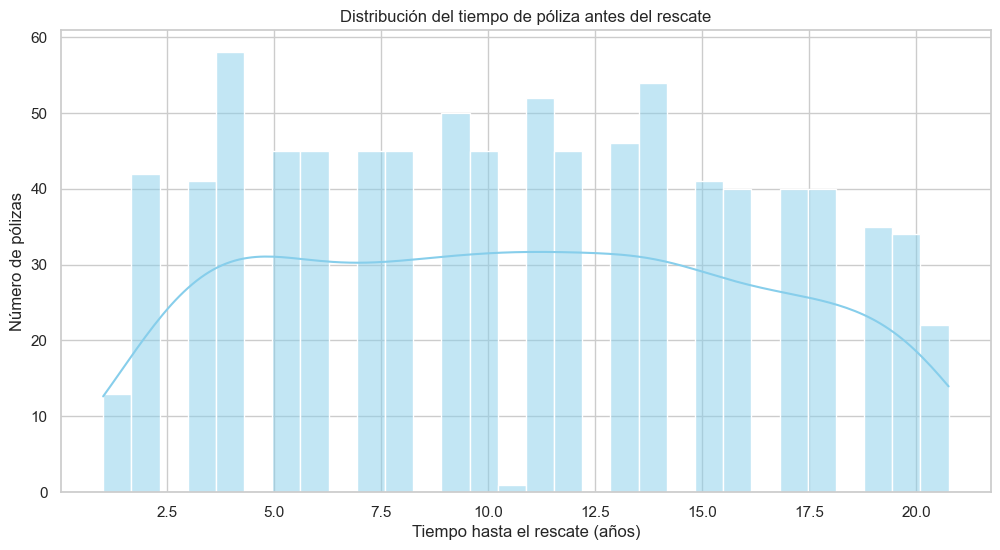

In [88]:
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear el histograma
plt.figure(figsize=(12, 6))
sns.histplot(rescued_policies['TIME_TO_RESCUE_YEARS'], bins=30, kde=True, color='skyblue')

# Configurar etiquetas y título
plt.xlabel('Tiempo hasta el rescate (años)')
plt.ylabel('Número de pólizas')
plt.title('Distribución del tiempo de póliza antes del rescate')

# Mostrar el gráfico
plt.show()

In [95]:
# def detect_outliers_percentile(data, column):
#     lower_bound = data[column].quantile(0.05)
#     upper_bound = data[column].quantile(0.95)
#     return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# def impute_outliers_with_mode(data, column, year_column):
#     outliers = detect_outliers_percentile(data, column)
#     for index, row in outliers.iterrows():
#         year = row[year_column]
#         mode_value = data[data[year_column] == year][column].mode()[0]
#         data.at[index, column] = mode_value
#     return data

# cartera = impute_outliers_with_mode(cartera, 'G_FUND_PC', 'ENTRY_YEAR')
cartera = cartera[cartera['G_FUND_PC']<=0.8]

C:\Users\mbuendiarascon\AppData\Local\Temp\ipykernel_14984\396896314.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='ENTRY_YEAR', y='G_FUND_PC', data=cartera, palette='viridis')


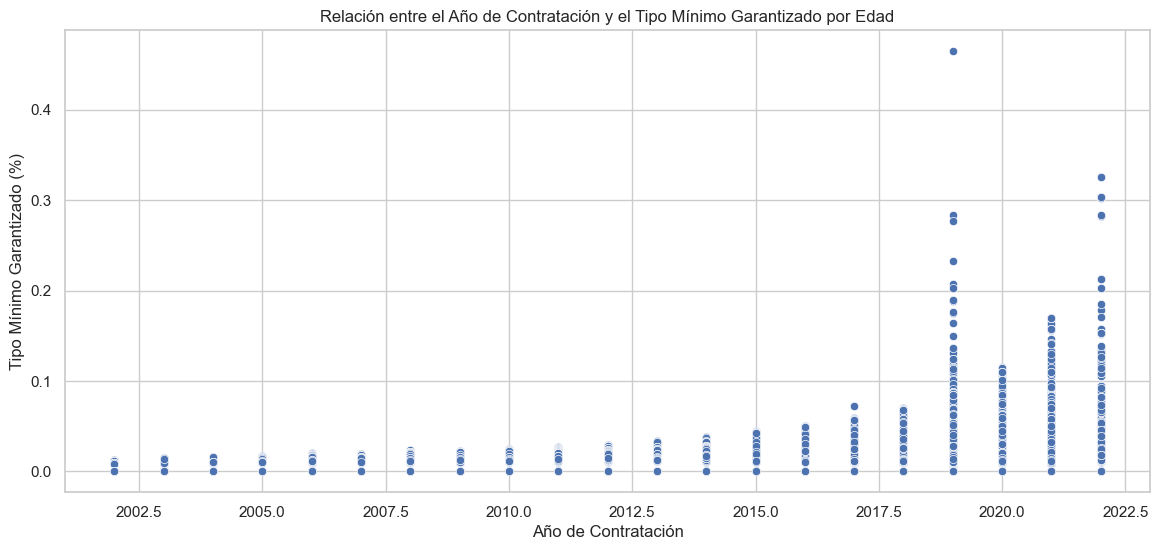

In [97]:

# Graficar la relación entre el año de contratación, la edad y el tipo mínimo garantizado
plt.figure(figsize=(14, 6))
sns.scatterplot(x='ENTRY_YEAR', y='G_FUND_PC', data=cartera, palette='viridis')
plt.title('Relación entre el Año de Contratación y el Tipo Mínimo Garantizado por Edad')
plt.xlabel('Año de Contratación')
plt.ylabel('Tipo Mínimo Garantizado (%)')
plt.show()
# plt.figure(figsize=(14, 6))
# sns.scatterplot(x='ENTRY_YEAR', y='G_FUND_PC', data=cartera, palette='viridis')

# plt.title('Relación entre el Año de Contratación y el Tipo Mínimo Garantizado por Edad')
# plt.xlabel('Año de Contratación')
# plt.ylabel('Tipo Mínimo Garantizado (%)')

# # Configurar el eje y con más valores
# y_min, y_max = cartera['G_FUND_PC'].min(), cartera['G_FUND_PC'].max()
# plt.yticks(np.linspace(y_min, y_max, num=15))  # Ajusta 'num' según sea necesario para más valores

# plt.show()

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
correlacion = cartera.drop(['SEX', 'RESCATE', 'PREM_FREQ', 'POL'], axis=1)

# Calculating the correlation matrix
correlation_matrix = correlacion.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

KeyboardInterrupt: 

In [64]:
threshold = 0.95
pares_correlacionados = [(correlation_matrix.index[i], correlation_matrix.columns[j])
                         for i in range(correlation_matrix.shape[0]) for j in range(i+1, correlation_matrix.shape[1])
                         if abs(correlation_matrix.iat[i, j]) > threshold]

# Mostrar pares altamente correlacionados
print("Pares de variables con alta correlación:")
for par in pares_correlacionados:
    print(par)

Pares de variables con alta correlación:
('EDAD', 'Ano_VTO')
('EDAD', 'RESTO_MESES_HASTA_VTO')
('DUR_ANOS', 'AGE_AT_ENTRY')
('DUR_ANOS', 'PREM_PAYBL_M')
('ANTIGÜEDAD', 'MESES_HASTA_PROJ')
('ANTIGÜEDAD', 'ENTRY_YEAR')
('ANTIGÜEDAD', 'POL_YEAR')
('Ano_VTO', 'RESTO_MESES_HASTA_VTO')
('MESES_HASTA_PROJ', 'ENTRY_YEAR')
('MESES_HASTA_PROJ', 'POL_YEAR')
('PU', 'PM_(FONDO)')
('INT_GAR', 'DIFF')
('ENTRY_YEAR', 'POL_YEAR')
('AGE_AT_ENTRY', 'PREM_PAYBL_M')


In [65]:
import seaborn as sns

## Interaccion de las variables con la variable target 
- Edad, Ano_VTO y RESTO_MESES_HASTA_PROJ (correlacion -1) vamos a ver si interactuan con la variable target de la misma manera 
- Ano_VTO y RESTO_MESES_HASTA_PROJ aportan la misma informacion, procedo a eliminar la variable RESTO_MESES_HASTA_PROJ

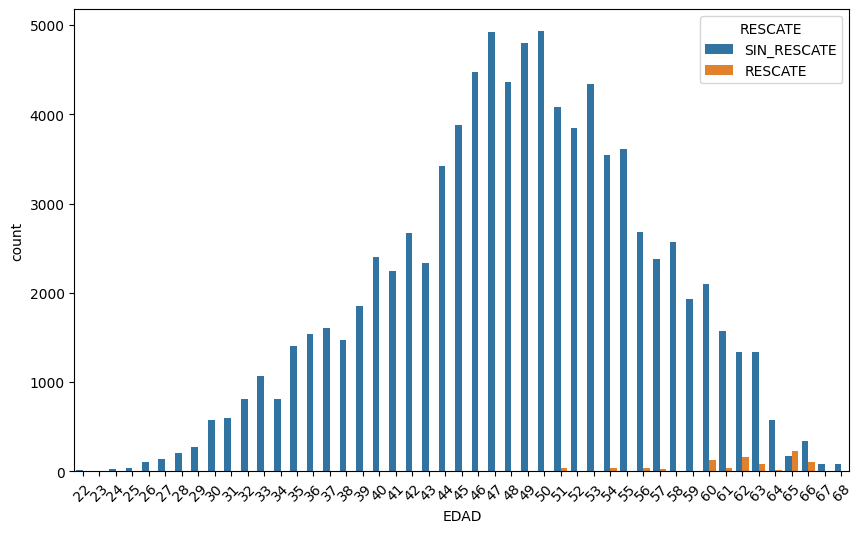

In [66]:
plt.figure(figsize=(10, 6))
sns.countplot(x='EDAD',hue='RESCATE', data=cartera)
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x 45 grados
plt.show()

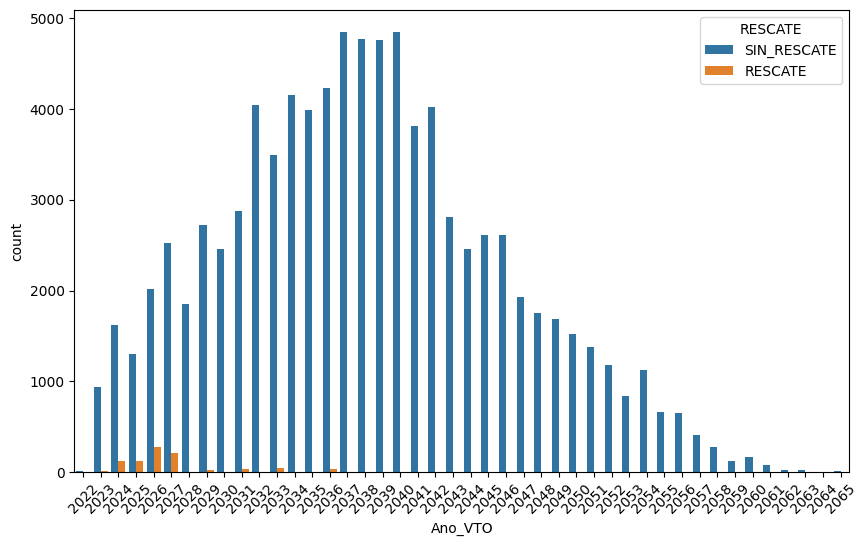

In [67]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Ano_VTO',hue='RESCATE', data=cartera)
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x 45 grados
plt.show()

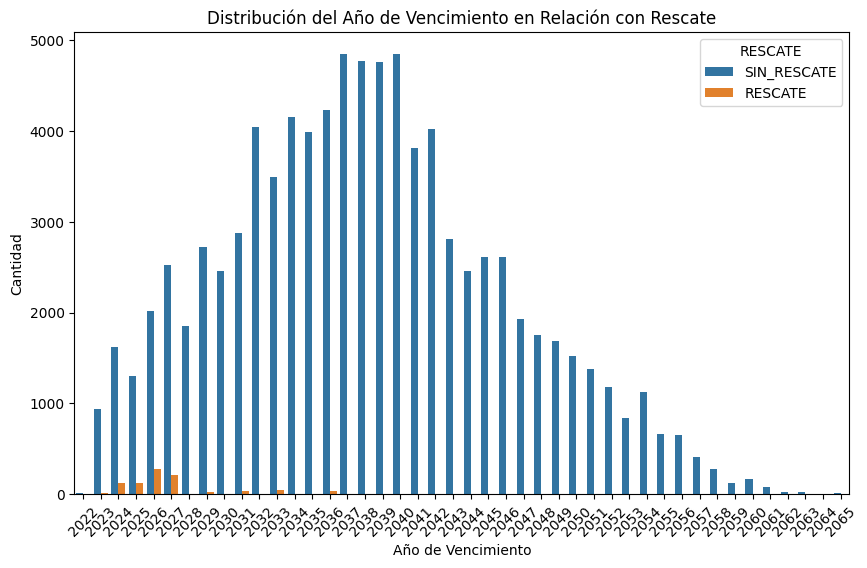

In [68]:
plt.figure(figsize=(10, 6))
sns.countplot(data=cartera, x='Ano_VTO', hue='RESCATE')
plt.title('Distribución del Año de Vencimiento en Relación con Rescate')
plt.xlabel('Año de Vencimiento')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x 45 grados
plt.show()

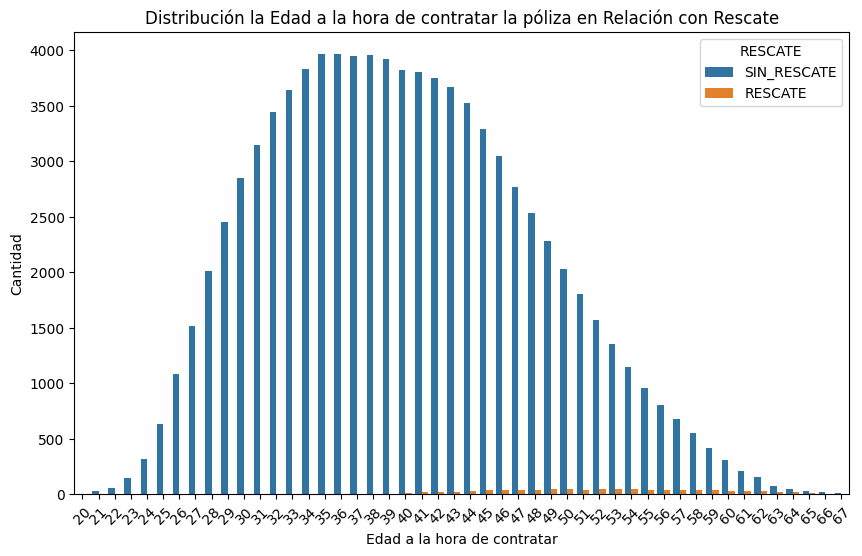

In [69]:
plt.figure(figsize=(10, 6))
sns.countplot(x='AGE_AT_ENTRY',hue='RESCATE', data=cartera)
plt.title('Distribución la Edad a la hora de contratar la póliza en Relación con Rescate')
plt.xlabel('Edad a la hora de contratar')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x 45 grados
plt.show()

<Axes: xlabel='RESTO_MESES_HASTA_VTO', ylabel='count'>

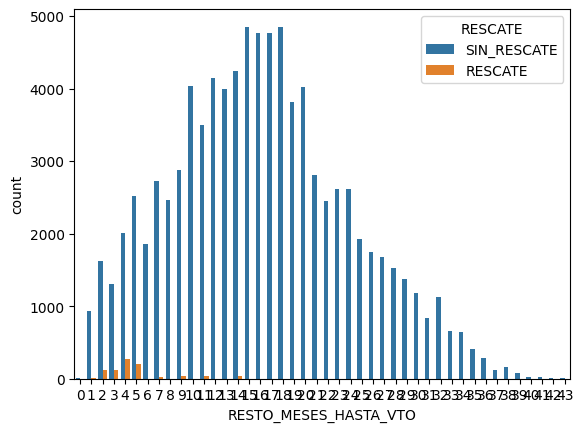

In [70]:
sns.countplot(x='RESTO_MESES_HASTA_VTO',hue='RESCATE', data=cartera)


In [71]:
cartera.columns

Index(['POL', 'EDAD', 'SEX', 'DUR_ANOS', 'ANTIGÜEDAD', 'Ano_VTO',
       'MESES_HASTA_PROJ', 'RESTO_MESES_HASTA_VTO', 'PU', 'INT_GAR',
       'PM_(FONDO)', 'DIFF', 'RESCATE', 'ENTRY_YEAR', 'AGE_AT_ENTRY',
       'POL_YEAR', 'PREM_PAYBL_M', 'ENTRY_MONTH', 'G_FUND_PC', 'PREM_FREQ'],
      dtype='object')

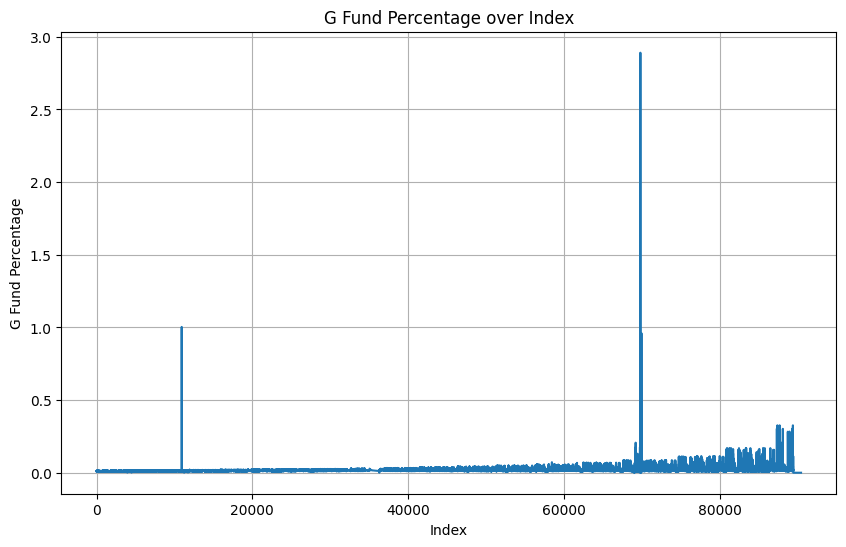

In [72]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=cartera.index, y='G_FUND_PC', data=cartera)
plt.xlabel('Index')
plt.ylabel('G Fund Percentage')
plt.title('G Fund Percentage over Index')
plt.grid(True)
plt.show()

In [73]:
cartera = cartera.drop('RESTO_MESES_HASTA_VTO', axis = 1)

### Mayor numero de rescates con tipos de interes de 0 o cerca al 0
- Las variables Diff y Int_GAR, aportan la misma informacion, con un interes garantizado menor se pueden observar mayores rescates, cuanto mas grande sea el diferencial entre interes garantizado y tipo de mercado hay mayor frecuencia de rescates. Lo cual tiene todo el sentido economico 

In [105]:
cartera['DIFF'] = cartera['DIFF'].round(2)

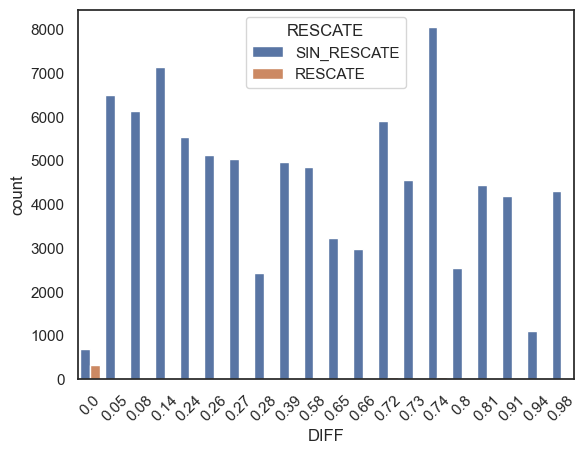

In [106]:
# make the variable DIFF only have to decimals

sns.countplot(x='DIFF',hue='RESCATE', data=cartera)
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x 45 grados
plt.show()


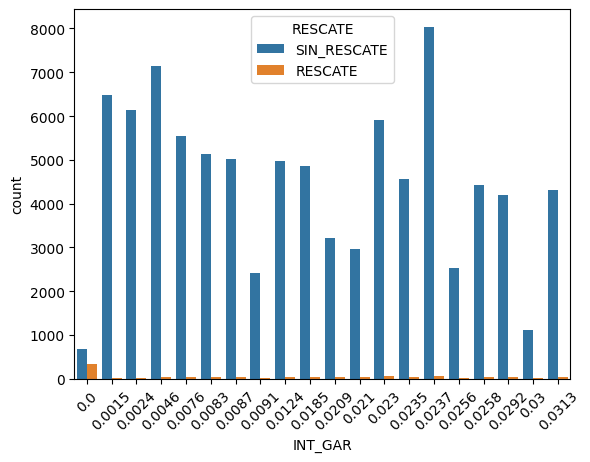

In [75]:
sns.countplot(x='INT_GAR',hue='RESCATE', data=cartera)
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x 45 grados
plt.show()

<Axes: xlabel='PREM_FREQ', ylabel='count'>

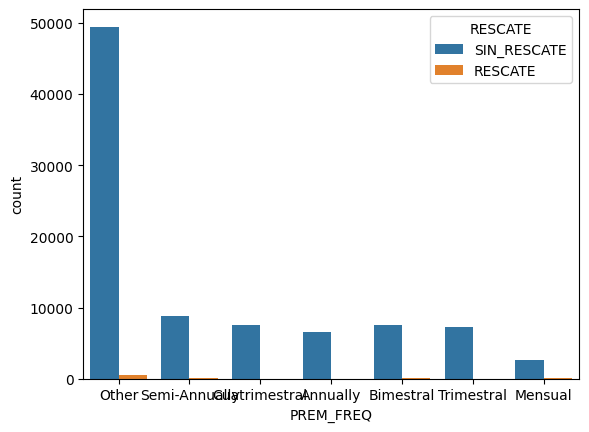

In [76]:
sns.countplot(x='PREM_FREQ',hue='RESCATE', data=cartera)

In [77]:
cartera = cartera.drop('INT_GAR', axis = 1)

#### Variable de genero no se diferencia el rescate y la antiguedad del cliente tampoco aporta ningun tipo de tendencia
- Soluciones para la antiguedad del cliente, hacer bins para ver si el poder predictivo aunmenta



<Axes: xlabel='SEX', ylabel='count'>

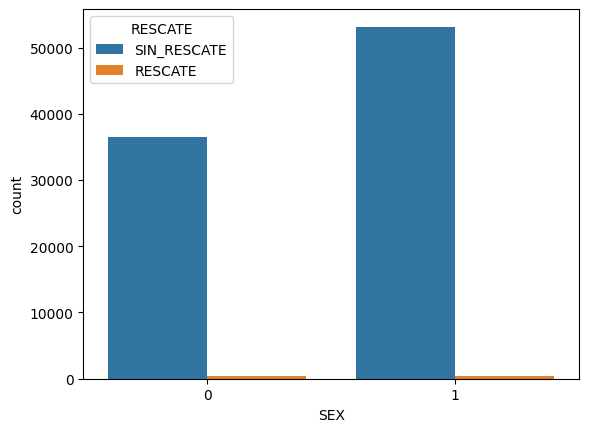

In [78]:
sns.countplot(x='SEX',hue='RESCATE', data=cartera) 

<Axes: xlabel='ANTIGÜEDAD', ylabel='count'>

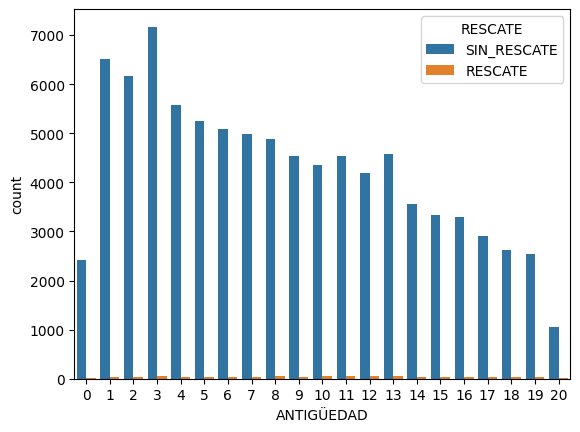

In [79]:
sns.countplot(x='ANTIGÜEDAD',hue='RESCATE', data=cartera) 

### Tendencia de rescate en años proximos a la finanlizacion de la poliza
- POL_YEAR y ENTRY_YEAR aportan la misma informacion procedo a eliminar ENTRY YEAR, pero a su vez estas dos variables me aportan la misma informacion que la antiguedad del cliente a si que elimino ambas varibales 

<Axes: xlabel='POL_YEAR', ylabel='count'>

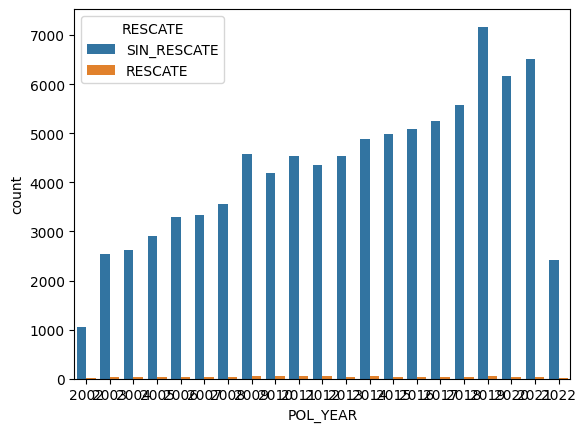

In [80]:
sns.countplot(x='POL_YEAR',hue='RESCATE', data=cartera)
# cartera = cartera.drop('ENTRY_YEAR', axis = 1)

In [81]:
cartera = cartera.drop('POL_YEAR', axis = 1)

### AGE_AT_ENTRY vs DUR_AÑOS
- me aportan la misma informacion de forma opuesta (no se como explicarlo)

<Axes: xlabel='DUR_ANOS', ylabel='count'>

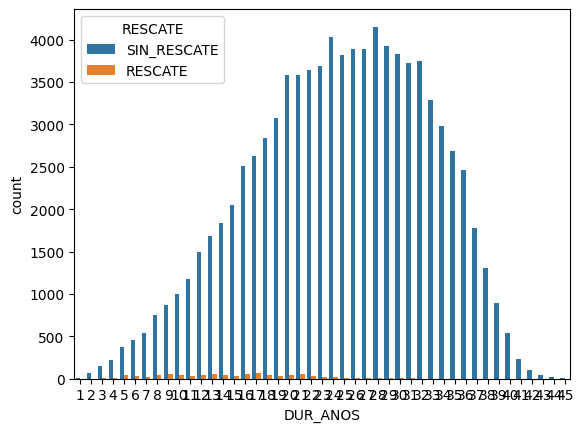

In [82]:
sns.countplot(x='DUR_ANOS',hue='RESCATE', data=cartera)

In [83]:
# entry month es una variable super sesgada con la mayor parte de los casos en el mes 12
# no se si tiene una capacidad predictiva alta  

In [84]:
cartera['ENTRY_MONTH'].value_counts()

ENTRY_MONTH
12    87809
9      1196
2       456
6       170
5       154
3       121
4       104
11      102
1       101
7       101
10       88
8        58
Name: count, dtype: int64

<Axes: xlabel='ENTRY_MONTH', ylabel='count'>

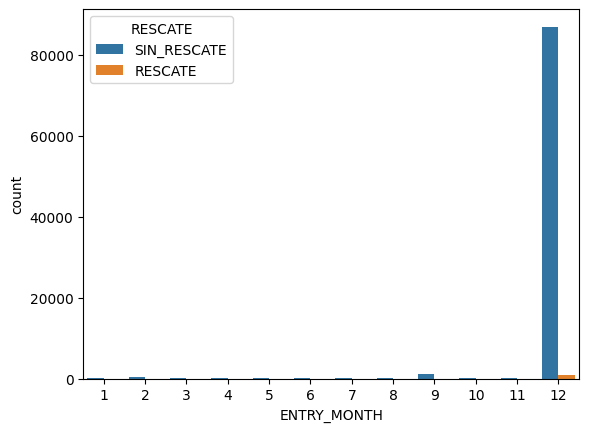

In [85]:
sns.countplot(x='ENTRY_MONTH',hue='RESCATE', data=cartera)

# Understanding de las correlaciones 
- Age at entry y perm payble tienen una correlacion negativa perfecta, cuanto mas joven es la persona mas pagan en premium, a medida que sube la edad baja el premium 
- Dur anos y age at entry tienen una correlacion negativa perfecta, ya que cuanto mas mayor es el cliente menos duracion tiene el producto que compra 
- Año VTO y edad les pasa lo mismo, hay una tendecia a que las polizas que estan mas cercanas a vencer es de los clientes mas mayores y los años de vto mas tardios sonde los clientes mas jovenes

In [86]:
# eliminar la variable mes_hasta_proj
cartera = cartera.drop('MESES_HASTA_PROJ', axis=1)

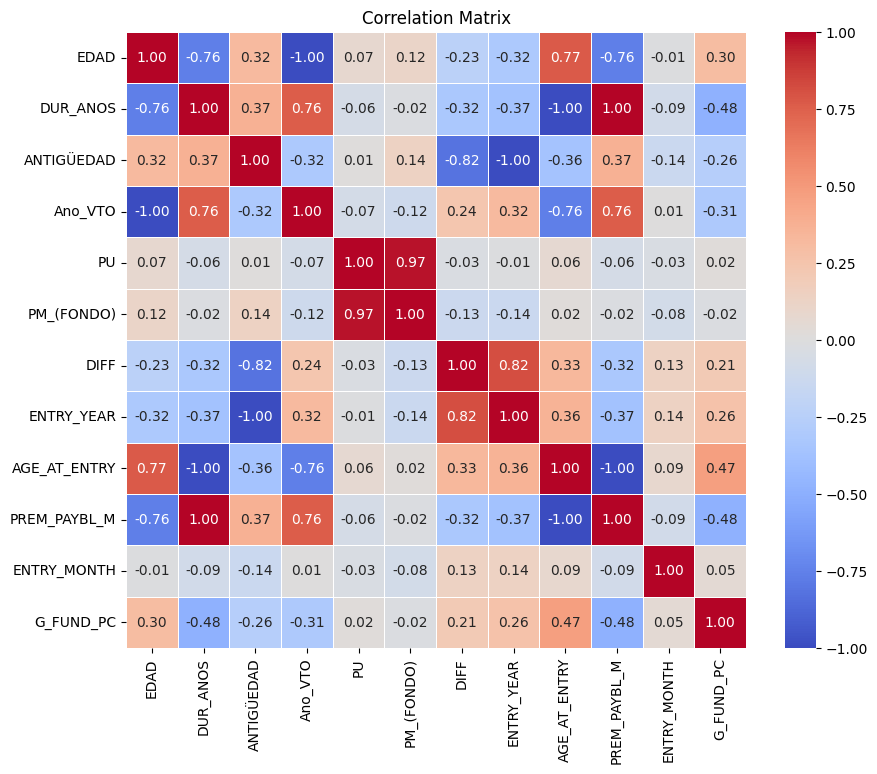

In [87]:
# Calculating the correlation matrix
correlacion = cartera.drop(['SEX', 'RESCATE', 'PREM_FREQ','POL'], axis=1)
correlation_matrix = correlacion.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Visualizacion de variables

In [88]:
cartera['SEX'] = cartera['SEX'].map({0: 'Female', 1: 'Male'})

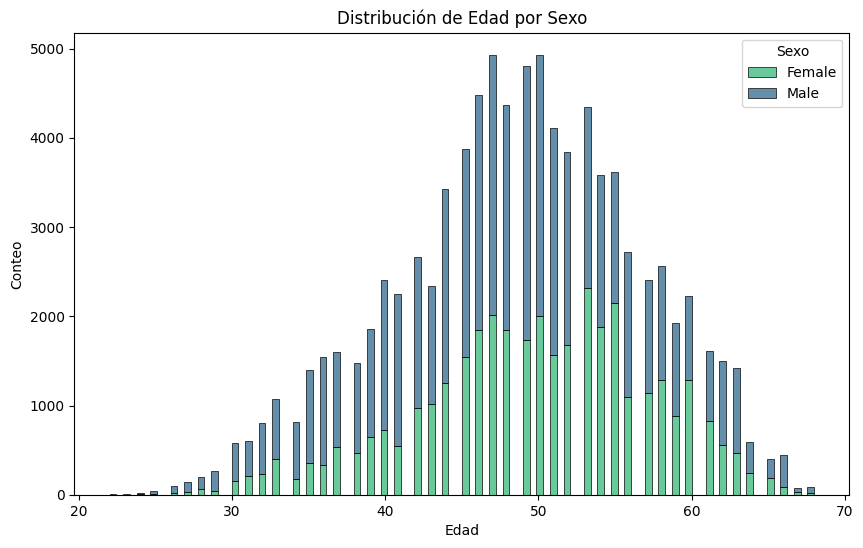

In [89]:
plt.figure(figsize=(10, 6))
sns.histplot(data=cartera, x='EDAD', hue='SEX', multiple='stack', palette='viridis')
plt.title('Distribución de Edad por Sexo')
plt.xlabel('Edad')
plt.ylabel('Conteo')
plt.legend(title='Sexo', labels=['Female', 'Male'])
plt.show()

In [90]:
cartera.columns

Index(['POL', 'EDAD', 'SEX', 'DUR_ANOS', 'ANTIGÜEDAD', 'Ano_VTO', 'PU',
       'PM_(FONDO)', 'DIFF', 'RESCATE', 'ENTRY_YEAR', 'AGE_AT_ENTRY',
       'PREM_PAYBL_M', 'ENTRY_MONTH', 'G_FUND_PC', 'PREM_FREQ'],
      dtype='object')

In [91]:
cartera['RESCATE'].unique

<bound method Series.unique of 0        SIN_RESCATE
1        SIN_RESCATE
2        SIN_RESCATE
3        SIN_RESCATE
4        SIN_RESCATE
            ...     
90455        RESCATE
90456        RESCATE
90457    SIN_RESCATE
90458    SIN_RESCATE
90459    SIN_RESCATE
Name: RESCATE, Length: 90460, dtype: object>

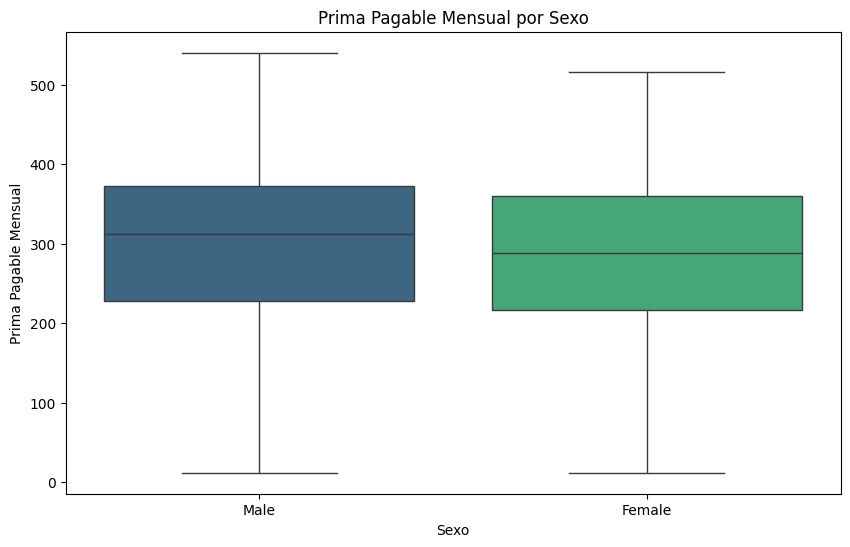

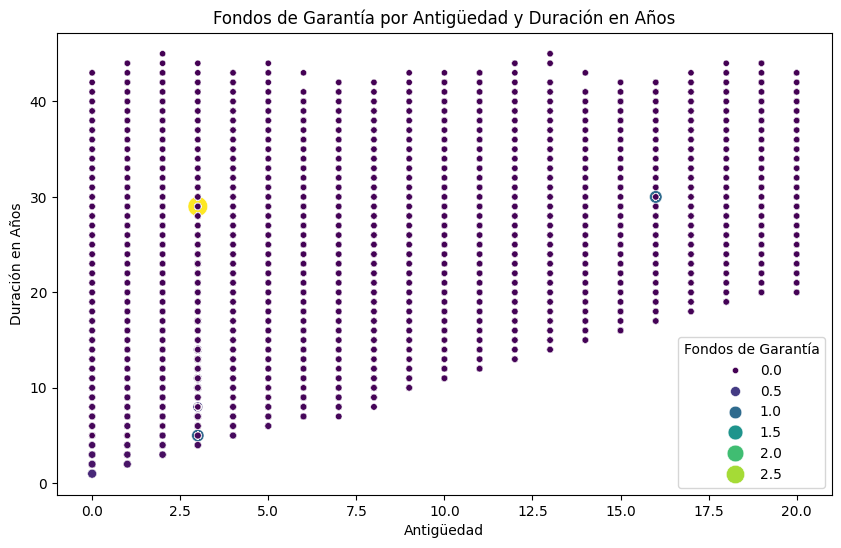

In [44]:
# 3. Prima Pagable Mensual por Sexo y Edad
plt.figure(figsize=(10, 6))
sns.boxplot(data=cartera, x='SEX', y='PREM_PAYBL_M', hue='SEX', palette='viridis')
plt.title('Prima Pagable Mensual por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Prima Pagable Mensual')
plt.show()

# 4. Fondos de Garantía por Antigüedad y Duración en Años
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cartera, x='ANTIGÜEDAD', y='DUR_ANOS', size='G_FUND_PC', hue='G_FUND_PC', palette='viridis', sizes=(20, 200))
plt.title('Fondos de Garantía por Antigüedad y Duración en Años')
plt.xlabel('Antigüedad')
plt.ylabel('Duración en Años')
plt.legend(title='Fondos de Garantía')
plt.show()


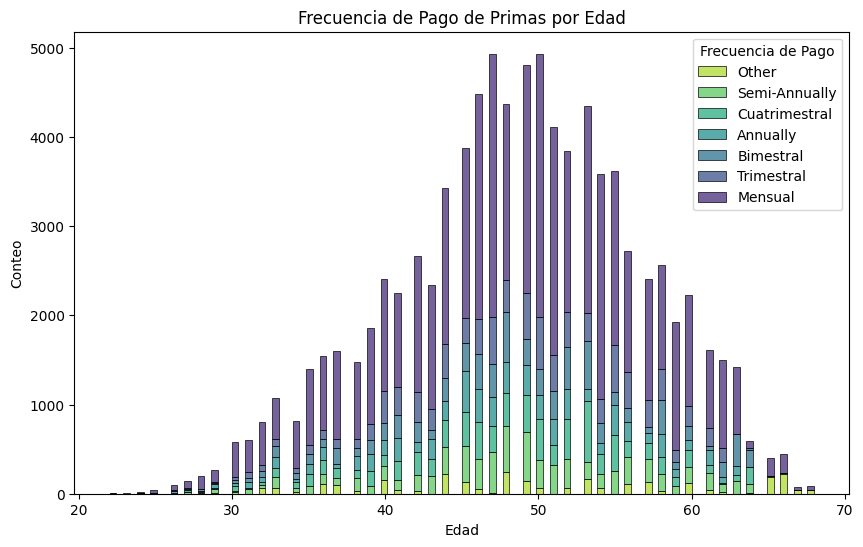

In [45]:

# 5. Frecuencia de Pago de Primas por Edad y Sexo
plt.figure(figsize=(10, 6))
sns.histplot(data=cartera, x='EDAD', hue='PREM_FREQ', multiple='stack', palette='viridis')
plt.title('Frecuencia de Pago de Primas por Edad')
plt.xlabel('Edad')
plt.ylabel('Conteo')
plt.legend(title='Frecuencia de Pago', labels=cartera['PREM_FREQ'].unique())
plt.show()


C:\Users\mbuendiarascon\AppData\Local\Temp\ipykernel_20488\3239912405.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=cartera, x='EDAD', y='G_FUND_PC', hue='SEX', ci=None, palette='viridis')


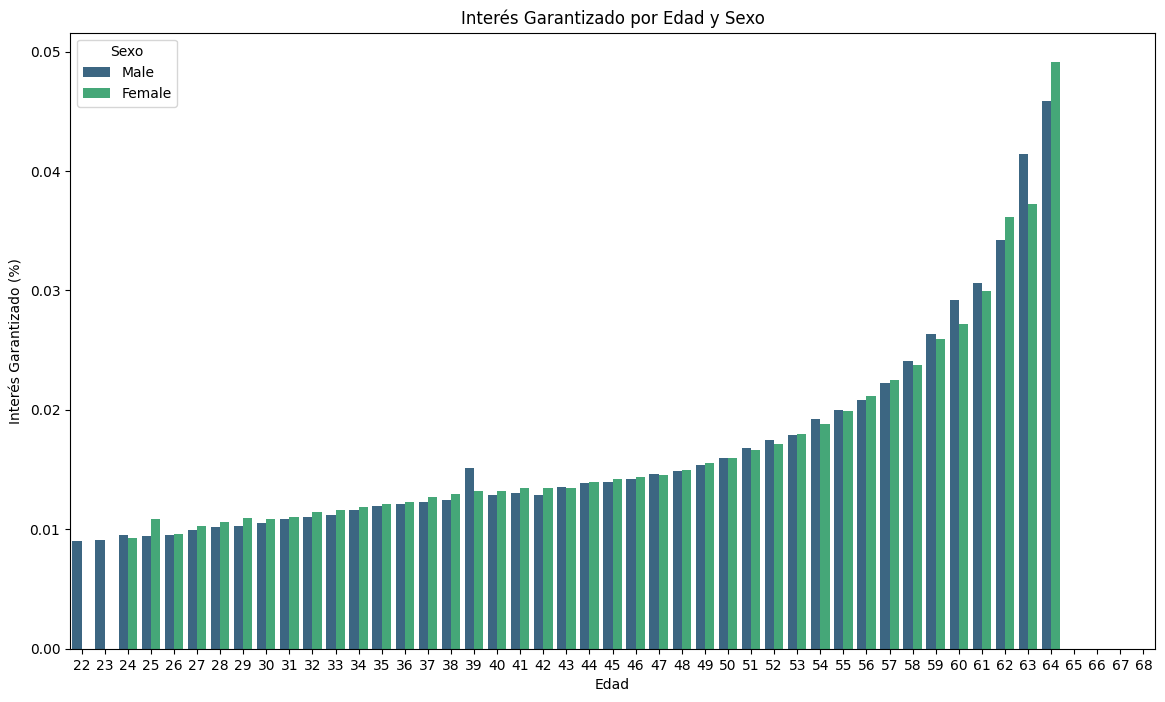

In [46]:
# 2. Interés Garantizado por Edad y Sexo
plt.figure(figsize=(14, 8))
sns.barplot(data=cartera, x='EDAD', y='G_FUND_PC', hue='SEX', ci=None, palette='viridis')
plt.title('Interés Garantizado por Edad y Sexo')
plt.xlabel('Edad')
plt.ylabel('Interés Garantizado (%)')
plt.legend(title='Sexo')
plt.show()


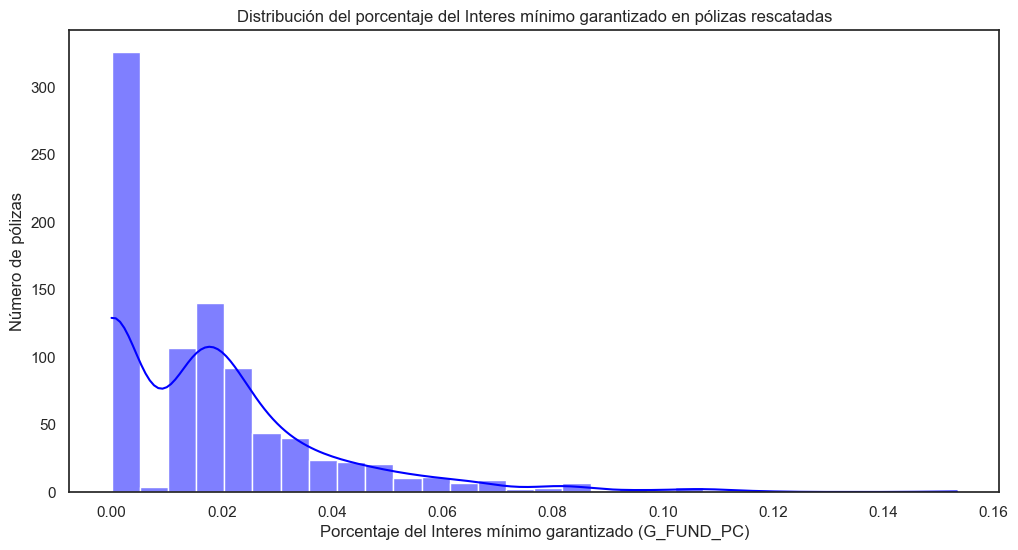

In [99]:

# Configurar el estilo de los gráficos
sns.set(style="white")

# Crear el histograma para G_FUND_PC
plt.figure(figsize=(12, 6))
sns.histplot(rescued_policies['G_FUND_PC'], bins=30, kde=True, color='blue')

# Configurar etiquetas y título
plt.xlabel('Porcentaje del Interes mínimo garantizado (G_FUND_PC)')
plt.ylabel('Número de pólizas')
plt.title('Distribución del porcentaje del Interes mínimo garantizado en pólizas rescatadas')

# Mostrar el gráfico
plt.show()

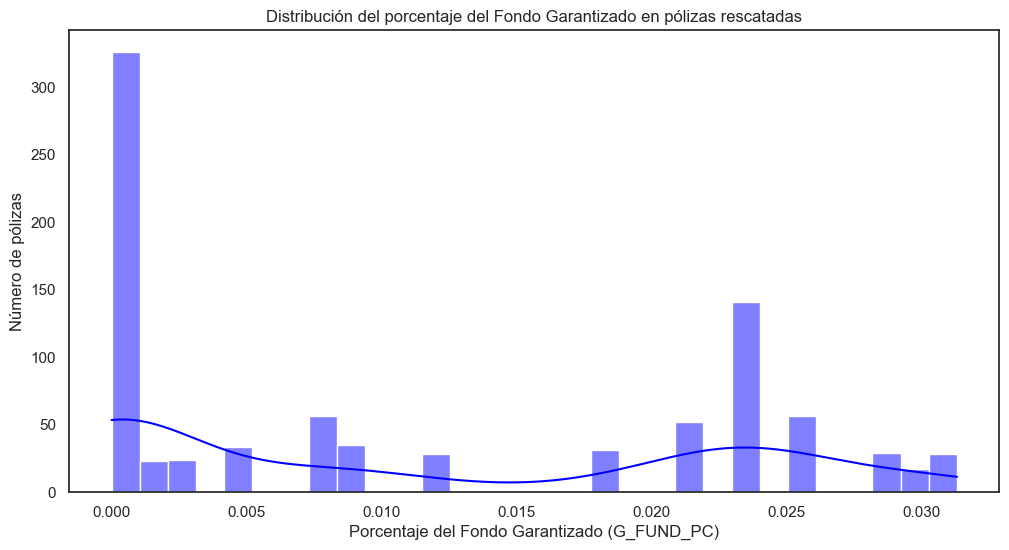

In [100]:

# Configurar el estilo de los gráficos
sns.set(style="white")

# Crear el histograma para G_FUND_PC
plt.figure(figsize=(12, 6))
sns.histplot(rescued_policies['INT_GAR'], bins=30, kde=True, color='blue')

# Configurar etiquetas y título
plt.xlabel('Porcentaje del Fondo Garantizado (G_FUND_PC)')
plt.ylabel('Número de pólizas')
plt.title('Distribución del porcentaje del Fondo Garantizado en pólizas rescatadas')

# Mostrar el gráfico
plt.show()

C:\Users\mbuendiarascon\AppData\Local\Temp\ipykernel_40460\2765416199.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='SEX', data=rescued_policies, palette='pastel', ax=axs[2, 0])
C:\Users\mbuendiarascon\AppData\Local\Temp\ipykernel_40460\2765416199.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2, 0].set_xticklabels(['Masculino', 'Femenino'])


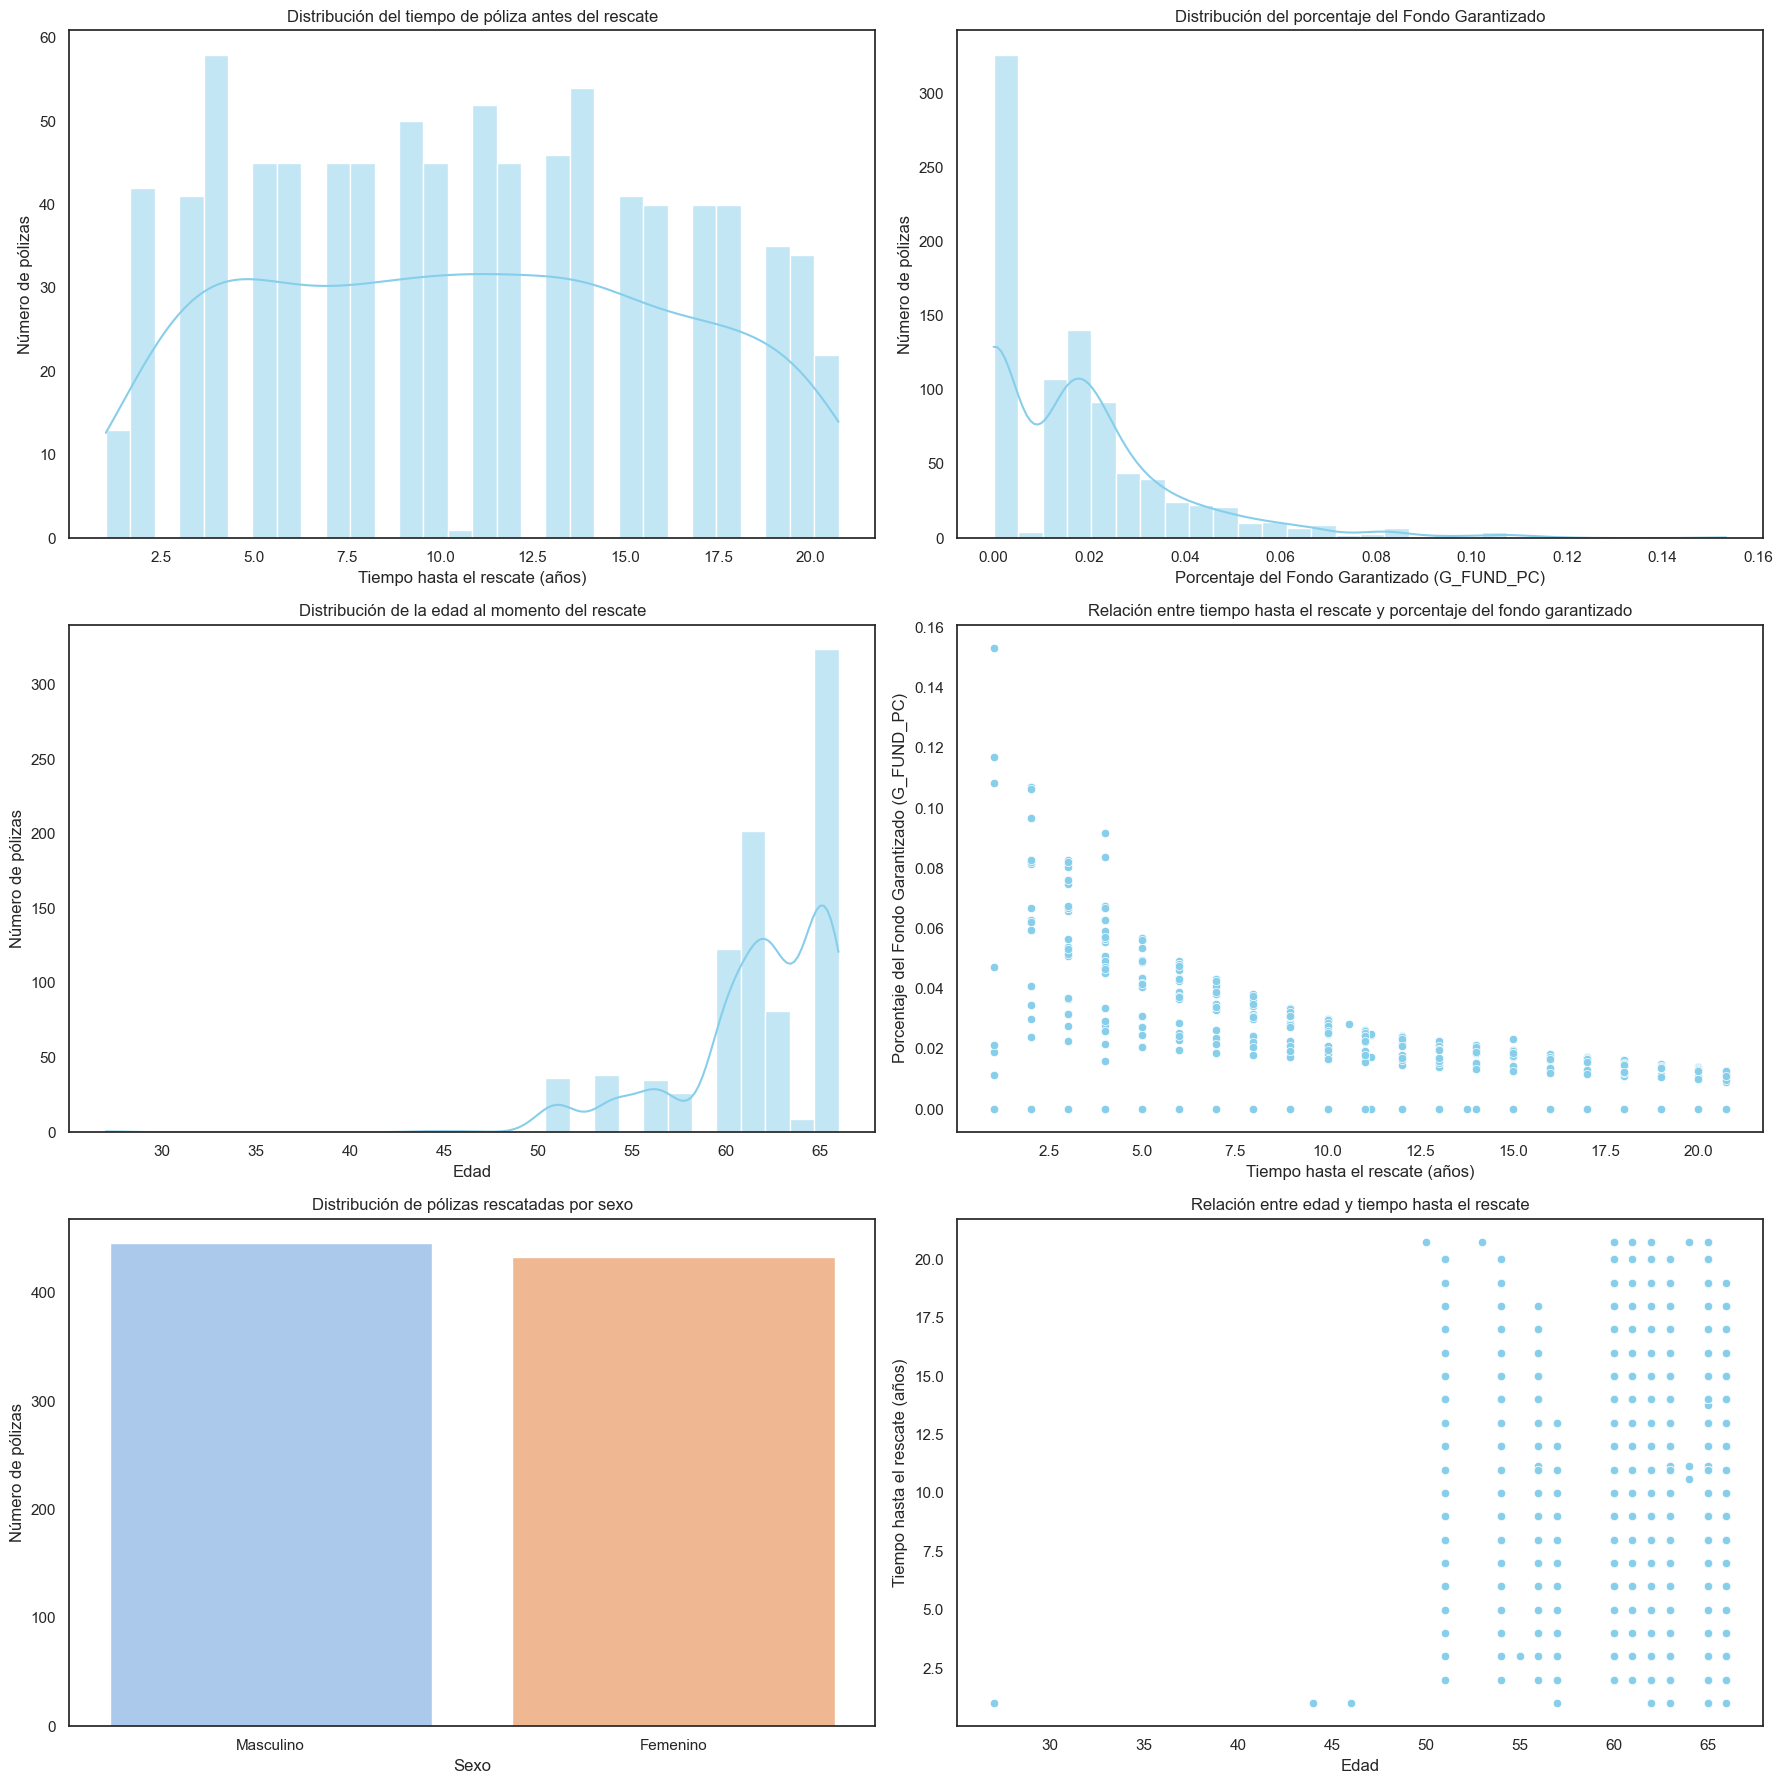

: 

In [130]:

# Configurar el estilo de los gráficos sin la cuadrícula
sns.set(style="white")

# Crear figuras y ejes
fig, axs = plt.subplots(3, 2, figsize=(18, 18))

# Distribución del tiempo hasta el rescate
sns.histplot(rescued_policies['TIME_TO_RESCUE_YEARS'], bins=30, kde=True, color='skyblue', ax=axs[0, 0])
axs[0, 0].set_title('Distribución del tiempo de póliza antes del rescate')
axs[0, 0].set_xlabel('Tiempo hasta el rescate (años)')
axs[0, 0].set_ylabel('Número de pólizas')

# Distribución del porcentaje del fondo garantizado (G_FUND_PC)
sns.histplot(rescued_policies['G_FUND_PC'], bins=30, kde=True, color='skyblue', ax=axs[0, 1])
axs[0, 1].set_title('Distribución del porcentaje del Fondo Garantizado')
axs[0, 1].set_xlabel('Porcentaje del Fondo Garantizado (G_FUND_PC)')
axs[0, 1].set_ylabel('Número de pólizas')

# Distribución de edad al momento del rescate
sns.histplot(rescued_policies['EDAD'], bins=30, kde=True, color='skyblue', ax=axs[1, 0])
axs[1, 0].set_title('Distribución de la edad al momento del rescate')
axs[1, 0].set_xlabel('Edad')
axs[1, 0].set_ylabel('Número de pólizas')

# Relación entre tiempo hasta el rescate y porcentaje del fondo garantizado
sns.scatterplot(x='TIME_TO_RESCUE_YEARS', y='G_FUND_PC', data=rescued_policies, color='skyblue', ax=axs[1, 1])
axs[1, 1].set_title('Relación entre tiempo hasta el rescate y porcentaje del fondo garantizado')
axs[1, 1].set_xlabel('Tiempo hasta el rescate (años)')
axs[1, 1].set_ylabel('Porcentaje del Fondo Garantizado (G_FUND_PC)')

# Distribución por sexo
sns.countplot(x='SEX', data=rescued_policies, palette='pastel', ax=axs[2, 0])
axs[2, 0].set_title('Distribución de pólizas rescatadas por sexo')
axs[2, 0].set_xlabel('Sexo')
axs[2, 0].set_ylabel('Número de pólizas')
axs[2, 0].set_xticklabels(['Masculino', 'Femenino'])

# Relación entre edad y tiempo hasta el rescate
sns.scatterplot(x='EDAD', y='TIME_TO_RESCUE_YEARS', data=rescued_policies, color='skyblue', ax=axs[2, 1])
axs[2, 1].set_title('Relación entre edad y tiempo hasta el rescate')
axs[2, 1].set_xlabel('Edad')
axs[2, 1].set_ylabel('Tiempo hasta el rescate (años)')

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()

C:\Users\mbuendiarascon\AppData\Local\Temp\ipykernel_30452\1214853945.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=cartera, x='EDAD', y='PREM_PAYBL_M', palette='viridis', ci=None)
C:\Users\mbuendiarascon\AppData\Local\Temp\ipykernel_30452\1214853945.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=cartera, x='EDAD', y='PREM_PAYBL_M', palette='viridis', ci=None)


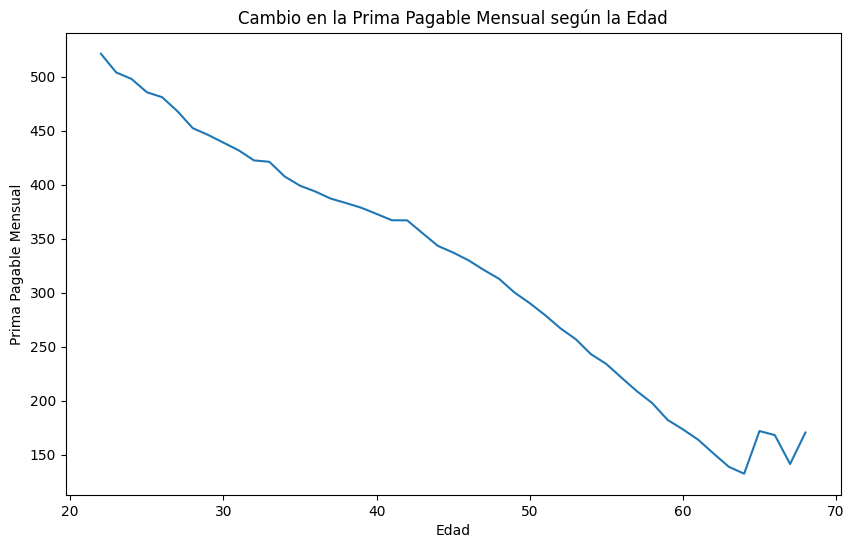

In [316]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=cartera, x='EDAD', y='PREM_PAYBL_M', palette='viridis', ci=None)
plt.title('Cambio en la Prima Pagable Mensual según la Edad')
plt.xlabel('Edad')
plt.ylabel('Prima Pagable Mensual')
plt.show()

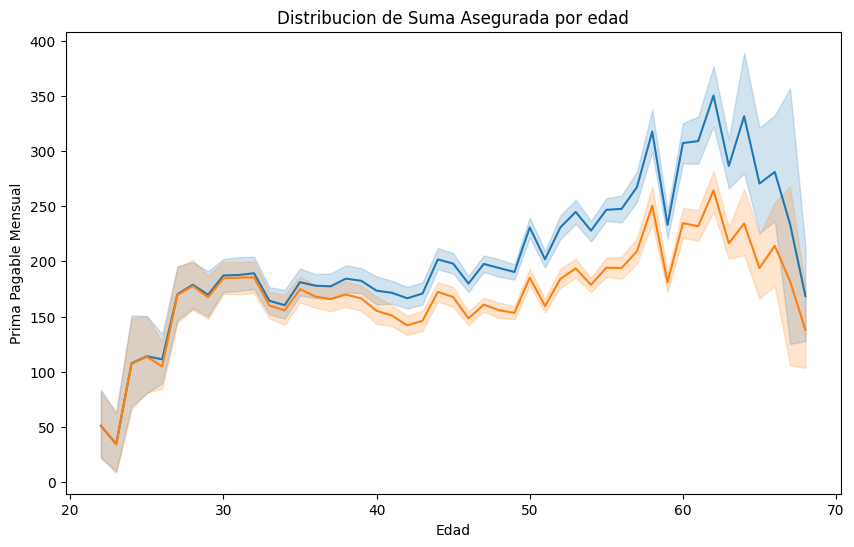

In [332]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=cartera, x='EDAD', y='PM_(FONDO)')
sns.lineplot(data=cartera, x='EDAD', y='PU')
plt.title('Distribucion de Suma Asegurada por edad')
plt.xlabel('Edad')
plt.ylabel('Prima Pagable Mensual')
plt.show()

# Cambiar los tipos a los correspondientes a las variables 

In [298]:
cartera.dtypes

POL              object
EDAD              int64
SEX              object
DUR_ANOS          int64
ANTIGÜEDAD        int64
Ano_VTO           int64
PU              float64
PM_(FONDO)      float64
DIFF            float64
RESCATE          object
AGE_AT_ENTRY      int64
PREM_PAYBL_M      int64
ENTRY_MONTH       int64
G_FUND_PC       float64
PREM_FREQ        object
dtype: object

In [299]:
# def cambiar_tipos(df):
#     # Definir las columnas que deben ser convertidas a categóricas
#     columnas_categoricas = [
#         'EDAD', 'DUR_ANOS', 'ANTIGÜEDAD', 'Ano_VTO', 
#         'AGE_AT_ENTRY', 'PREM_PAYBL_M', 'ENTRY_MONTH'
#     ]
#     # Convertir las columnas a categóricas
#     for col in columnas_categoricas:
#         df[col] = df[col].astype('category')
#     # Convertir SEX a objeto (string)
#     df['SEX'] = df['SEX'].astype('object')
    
#     return df

In [300]:
# cartera = cambiar_tipos(cartera)

In [301]:
# cartera.dtypes

# PCA 
mirar la multicolinearidad, como afecta al rendimiento de los modelos, si se ven muy afectados, hacer una PCA

In [302]:
# cartera['SEX'] = cartera['SEX'].replace({'H': 1, 'M': 0})
cartera['RESCATE'] = cartera['RESCATE'].replace({'RESCATE': 1, 'SIN_RESCATE': 0})

C:\Users\mbuendiarascon\AppData\Local\Temp\ipykernel_30452\3272521274.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cartera['RESCATE'] = cartera['RESCATE'].replace({'RESCATE': 1, 'SIN_RESCATE': 0})


TRATAMIENTO DE OUTLIERS

In [303]:
#transformaciones logaritmicas a las variables que estan muy hacia la derecha


# Tratamiento de las variables 
- No voy a estandarizar ni normalizar variables de momento ya que :
    - Estandarización: Escala las variables para que tengan media 0 y desviación estándar 1. Es útil para algoritmos que asumen que los datos están centrados alrededor de cero, como la regresión lineal y el PCA.
    - Normalización: Escala las variables para que estén entre 0 y 1. Es útil para algoritmos que no hacen suposiciones sobre la distribución de los datos, como redes neuronales
    - Sin embargo, voy a transformar algunas variables para que sean más fáciles de analizar
- usando transformacion de box-cox:
- La transformación de Box-Cox es una técnica utilizada para estabilizar la varianza de las variables 
    - O igual tambien hago transformacion logaritmiza  a las variables que tienen distribuciones sesgadas (skewed) [entry_month, PM_(FONDO), PU]

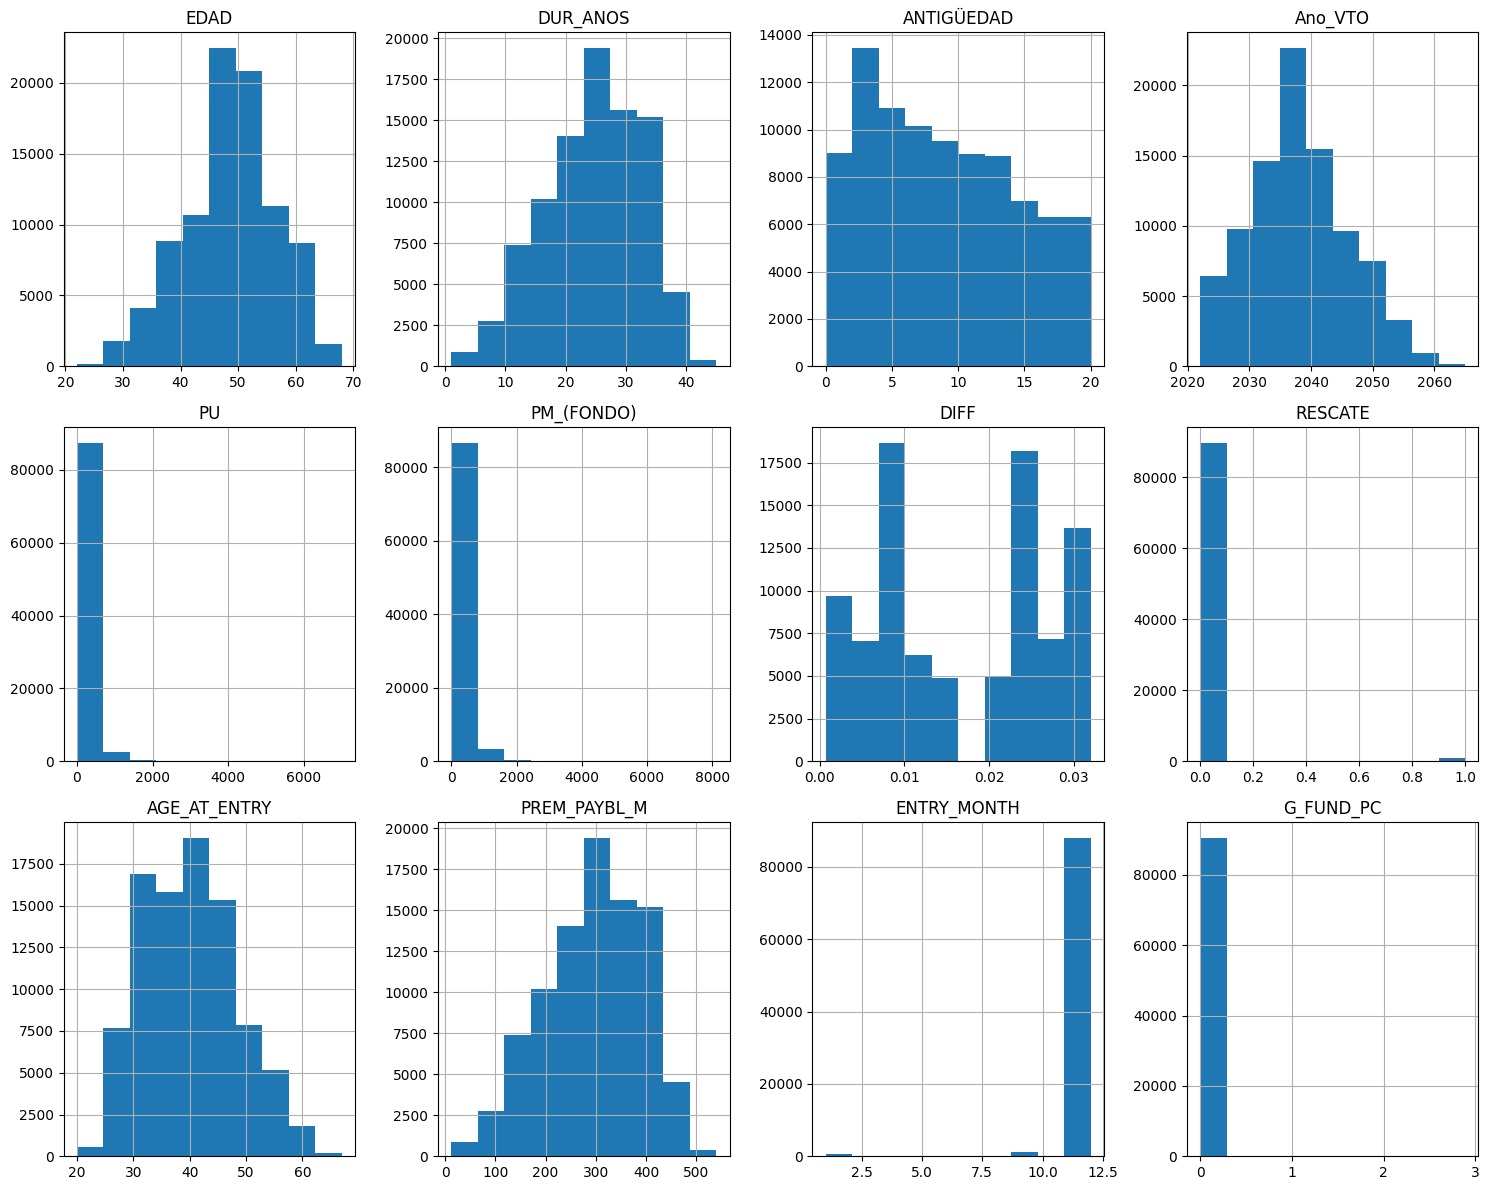

In [304]:
# Variables numericas
# plt.figure(figsize=(12, 8))
# for i, col in enumerate(cartera.select_dtypes(include='number'), 1):
#     plt.subplot(3, 4, i)
#     cartera[col].hist()
#     plt.title(col)
# plt.tight_layout()
# plt.show()
numerical_columns = cartera.select_dtypes(include='number').columns

# Calculate the number of rows and columns for subplots
num_cols = 4
num_rows = int(np.ceil(len(numerical_columns) / num_cols))

plt.figure(figsize=(15, num_rows * 4))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    cartera[col].hist()
    plt.title(col)

plt.tight_layout()
plt.show()

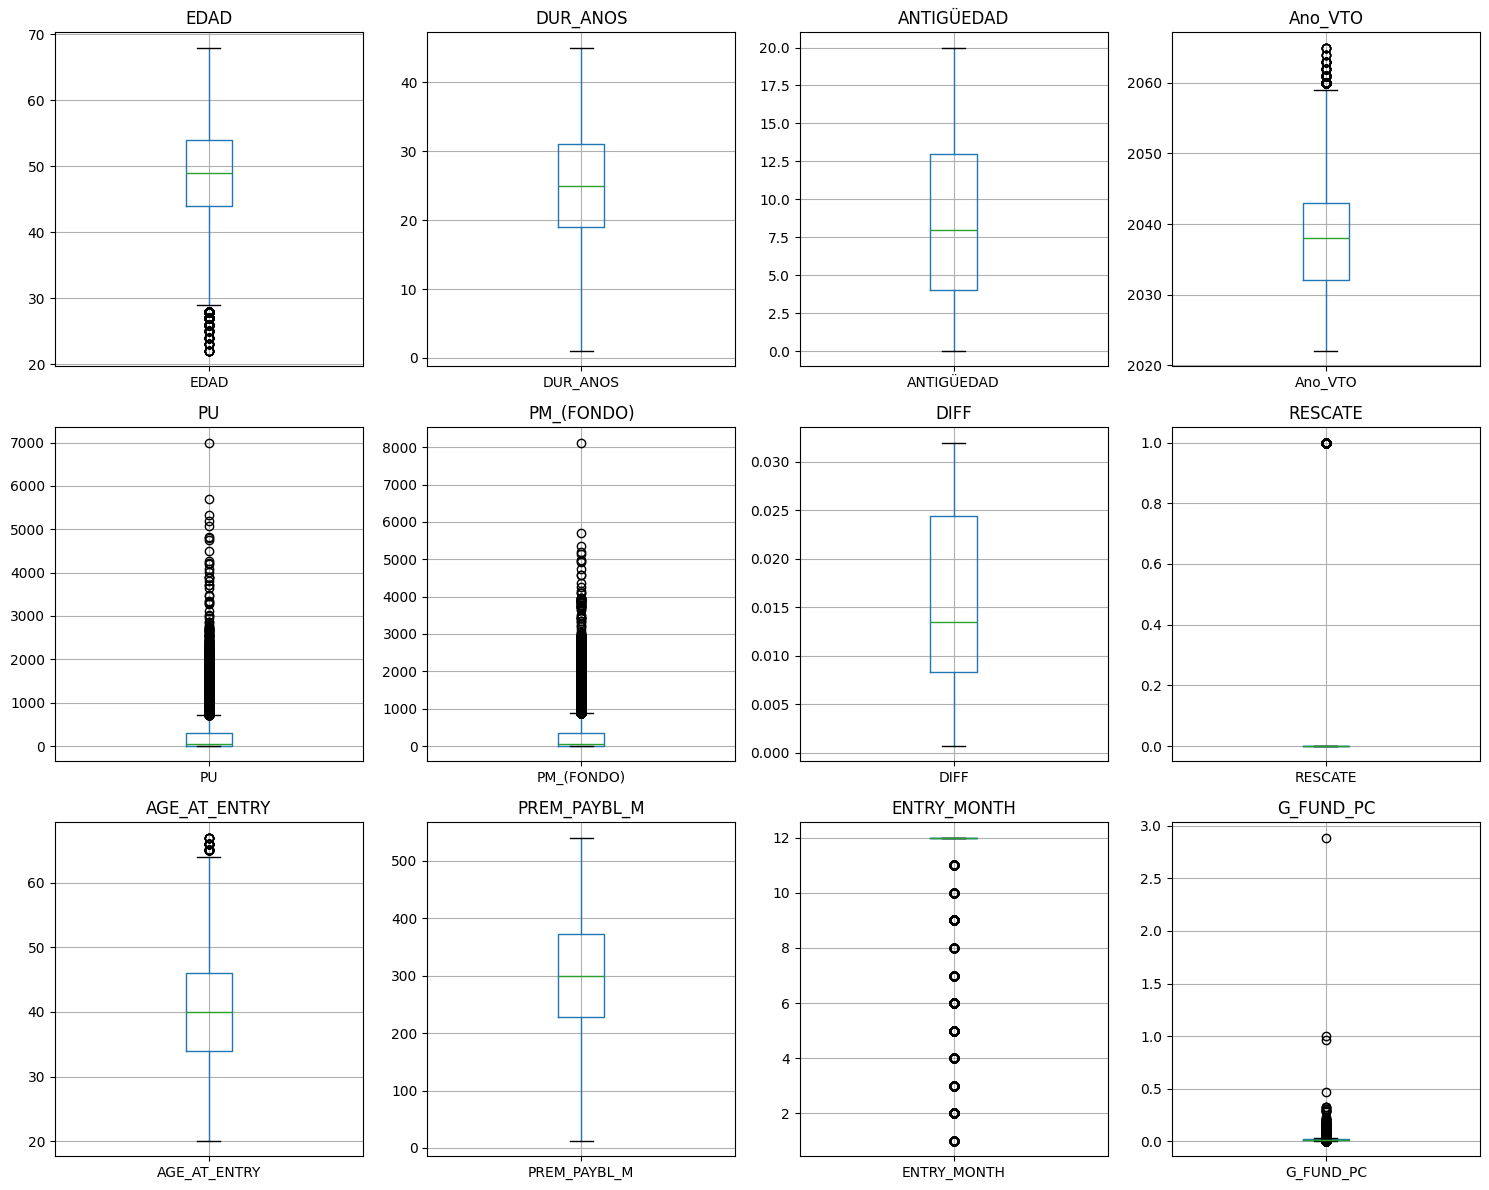

In [305]:
# #variable numericas
# plt.figure(figsize=(12, 8))
# for i, col in enumerate(cartera.select_dtypes(include='number'), 1):
#     plt.subplot(3, 4, i)
#     cartera.boxplot(column=col)
#     plt.title(col)
# plt.tight_layout()
# plt.show()
num_cols = 4
num_rows = int(np.ceil(len(numerical_columns) / num_cols))

plt.figure(figsize=(15, num_rows * 4))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    cartera.boxplot(column=col)
    plt.title(col)

plt.tight_layout()
plt.show()


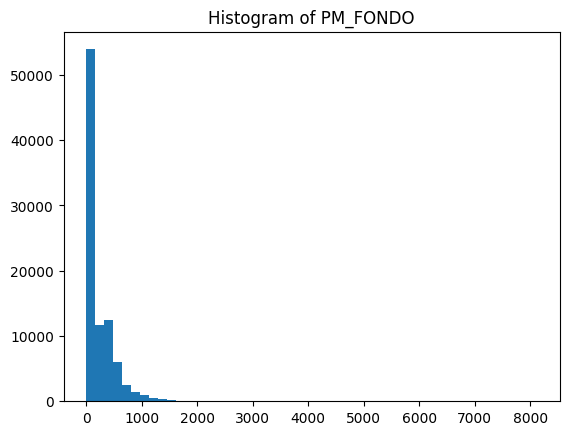

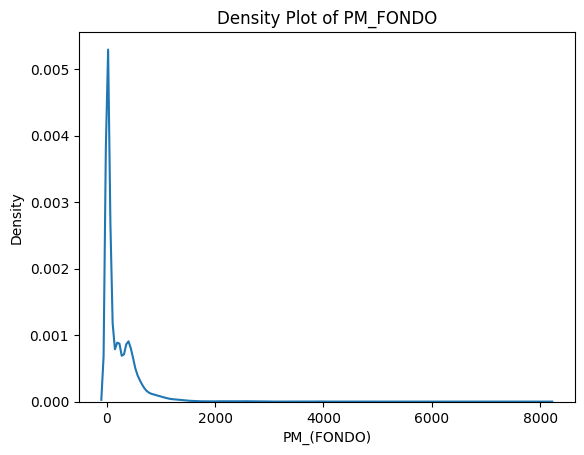

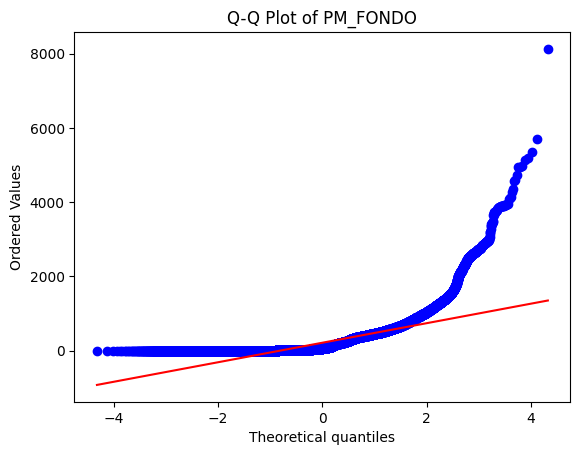

In [306]:
import matplotlib.pyplot as plt

# Histogram
plt.hist(cartera['PM_(FONDO)'], bins=50)
plt.title('Histogram of PM_FONDO')
plt.show()

# Density plot
import seaborn as sns
sns.kdeplot(cartera['PM_(FONDO)'])
plt.title('Density Plot of PM_FONDO')
plt.show()

# Q-Q plot
import scipy.stats as stats
stats.probplot(cartera['PM_(FONDO)'], dist='norm', plot=plt)
plt.title('Q-Q Plot of PM_FONDO')
plt.show()

# Version 1 transformacion box-cox
 Se puede observar que tanto la transformacion logaritmica como la transformacion Box-Cox reducen el skewness y kutosis de la variable, pero Box-Cox parece tener algo mejores de valores de skewness y kurtosis 


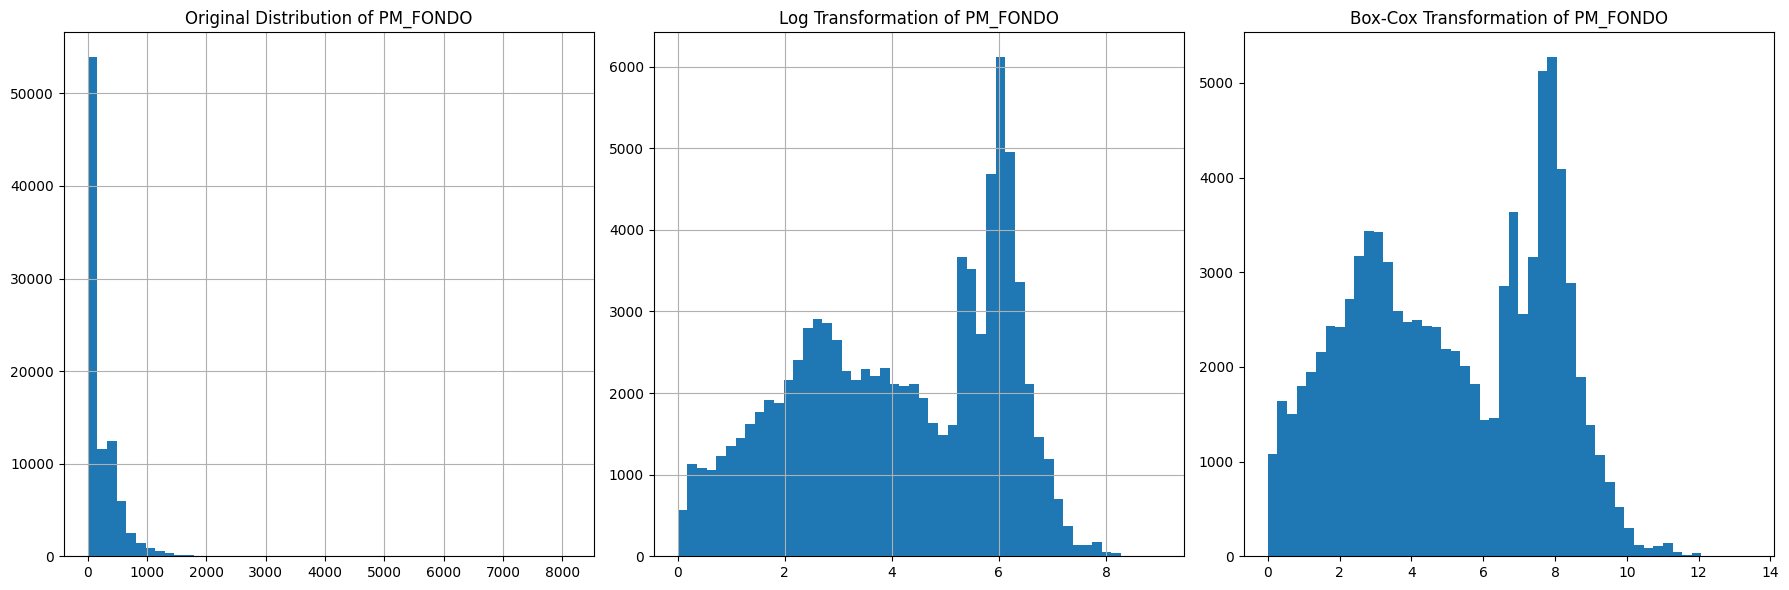

,Skewness,Kurtosis
Original,3.707698,28.436606
Log,-0.259237,-1.099937
Box-Cox,-0.063735,-1.184441


In [307]:
from scipy import stats
plt.figure(figsize=(18, 6))

# Original distribution
plt.subplot(1, 3, 1)
cartera['PM_(FONDO)'].hist(bins=50)
plt.title('Original Distribution of PM_FONDO')

# Log transformation
plt.subplot(1, 3, 2)
np.log1p(cartera['PM_(FONDO)']).hist(bins=50)
plt.title('Log Transformation of PM_FONDO')

# Box-Cox transformation
plt.subplot(1, 3, 3)
# Adding 1 to ensure all values are positive since Box-Cox requires positive values
boxcox_transformed, _ = stats.boxcox(cartera['PM_(FONDO)'] + 1)
plt.hist(boxcox_transformed, bins=50)
plt.title('Box-Cox Transformation of PM_FONDO')

plt.tight_layout()
plt.show()

# Calculate skewness and kurtosis
original_skew = cartera['PM_(FONDO)'].skew()
original_kurt = cartera['PM_(FONDO)'].kurtosis()

log_skew = np.log1p(cartera['PM_(FONDO)']).skew()
log_kurt = np.log1p(cartera['PM_(FONDO)']).kurtosis()

boxcox_skew = pd.Series(boxcox_transformed).skew()
boxcox_kurt = pd.Series(boxcox_transformed).kurtosis()

# Display results
results = pd.DataFrame({
    'Skewness': [original_skew, log_skew, boxcox_skew],
    'Kurtosis': [original_kurt, log_kurt, boxcox_kurt]
}, index=['Original', 'Log', 'Box-Cox'])
results

In [308]:
numerical_features = cartera.select_dtypes(include=[np.number])
skewness = numerical_features.skew().sort_values(ascending=False)
print("Asimetría de las variables:")
print(skewness)

Asimetría de las variables:
G_FUND_PC       82.073239
RESCATE          9.996276
PU               3.834256
PM_(FONDO)       3.707698
AGE_AT_ENTRY     0.321997
ANTIGÜEDAD       0.309253
Ano_VTO          0.299709
DIFF             0.024478
EDAD            -0.236036
DUR_ANOS        -0.282681
PREM_PAYBL_M    -0.282681
ENTRY_MONTH     -7.785444
dtype: float64


### Los valores que esten por encima del 0.75 de asimetria realizar la transformacion de box-cox

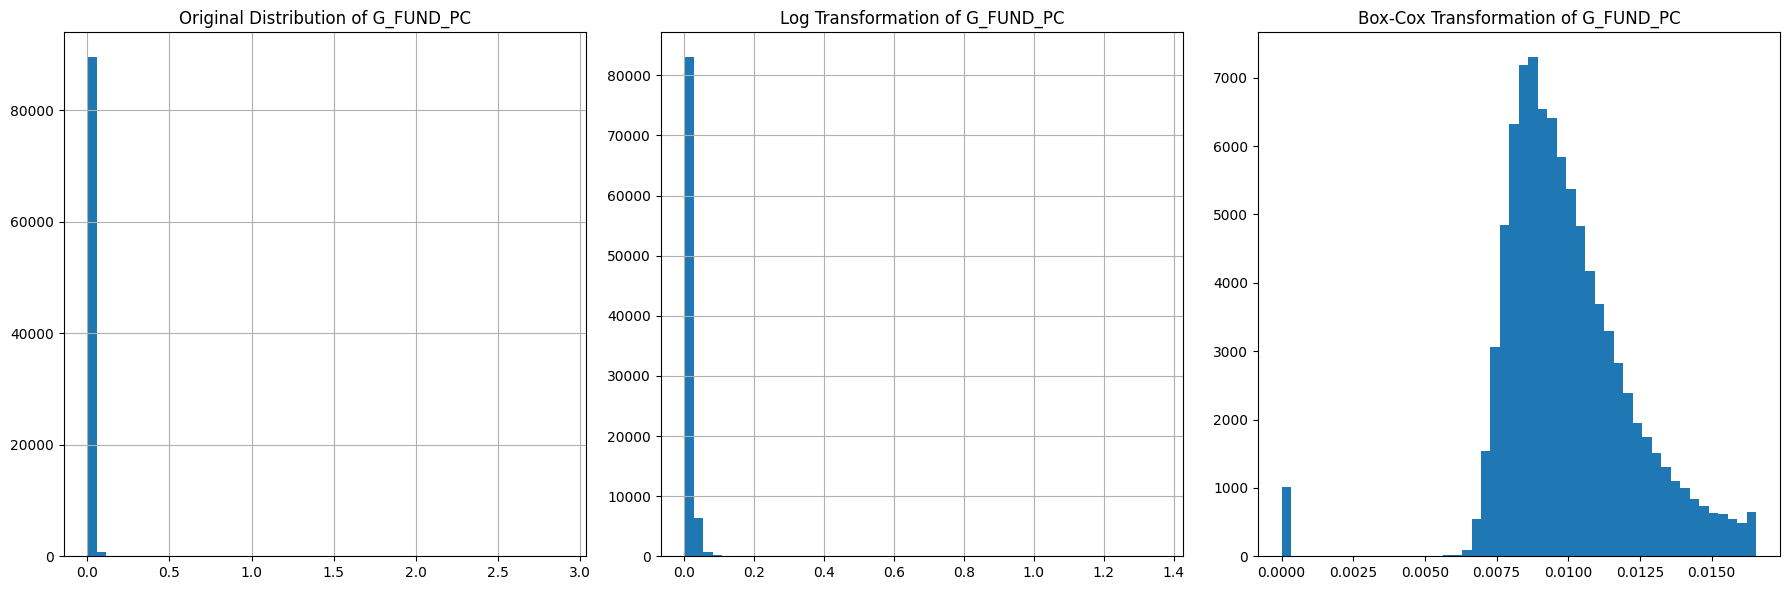

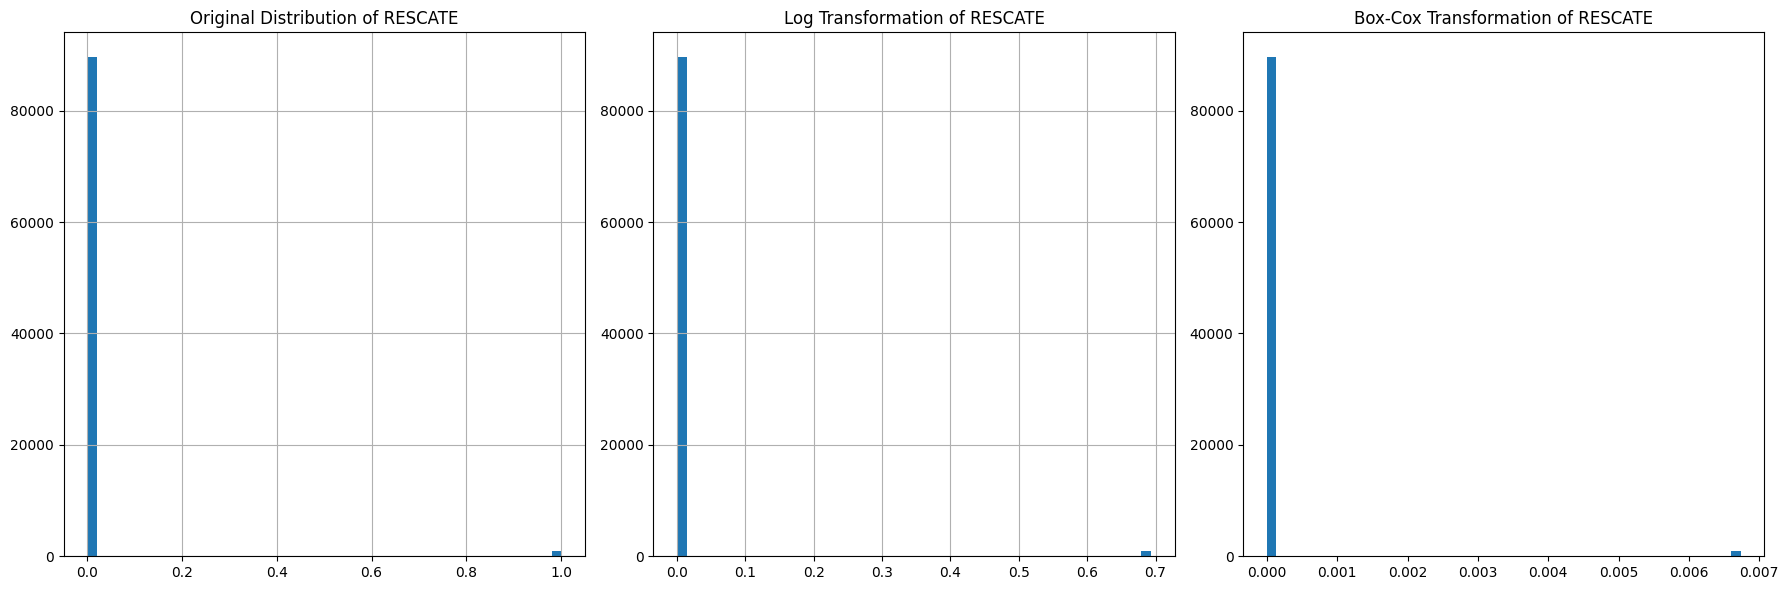

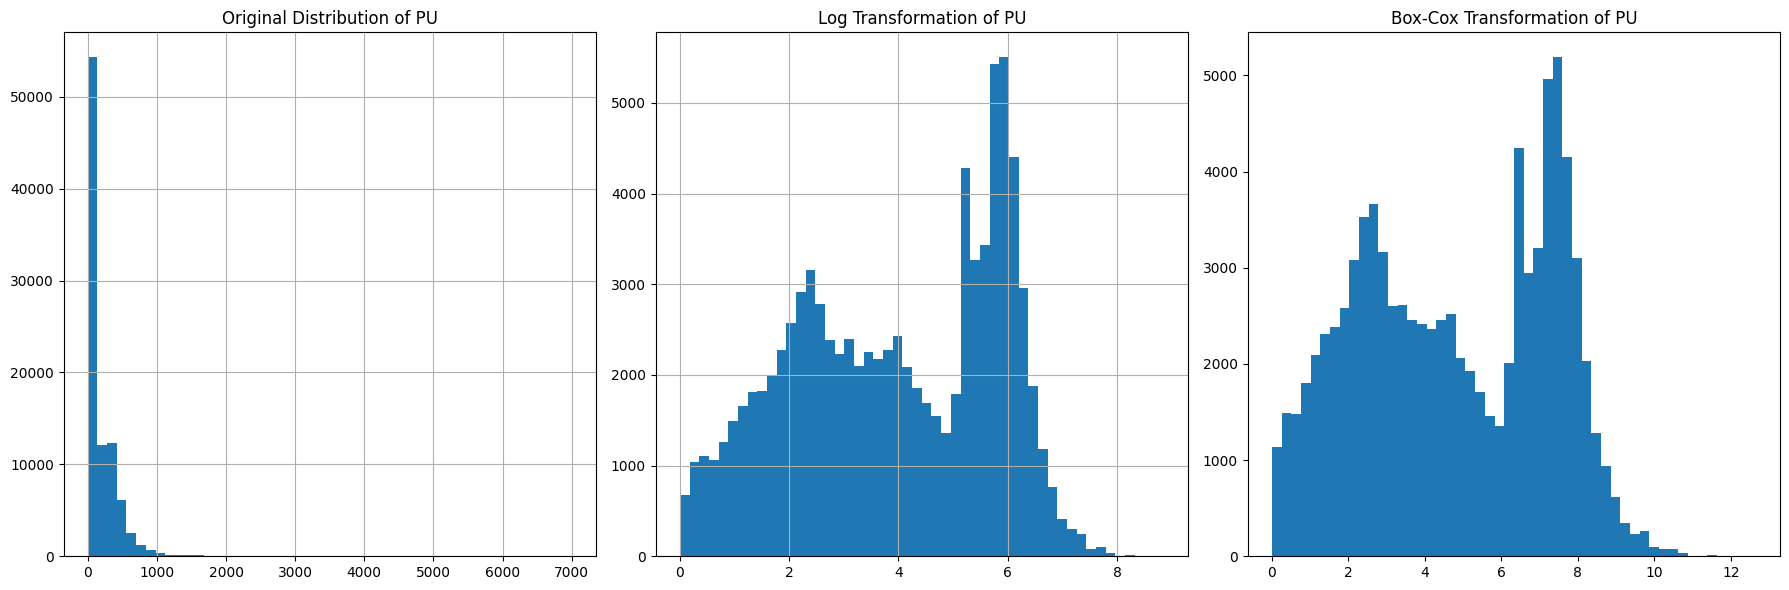

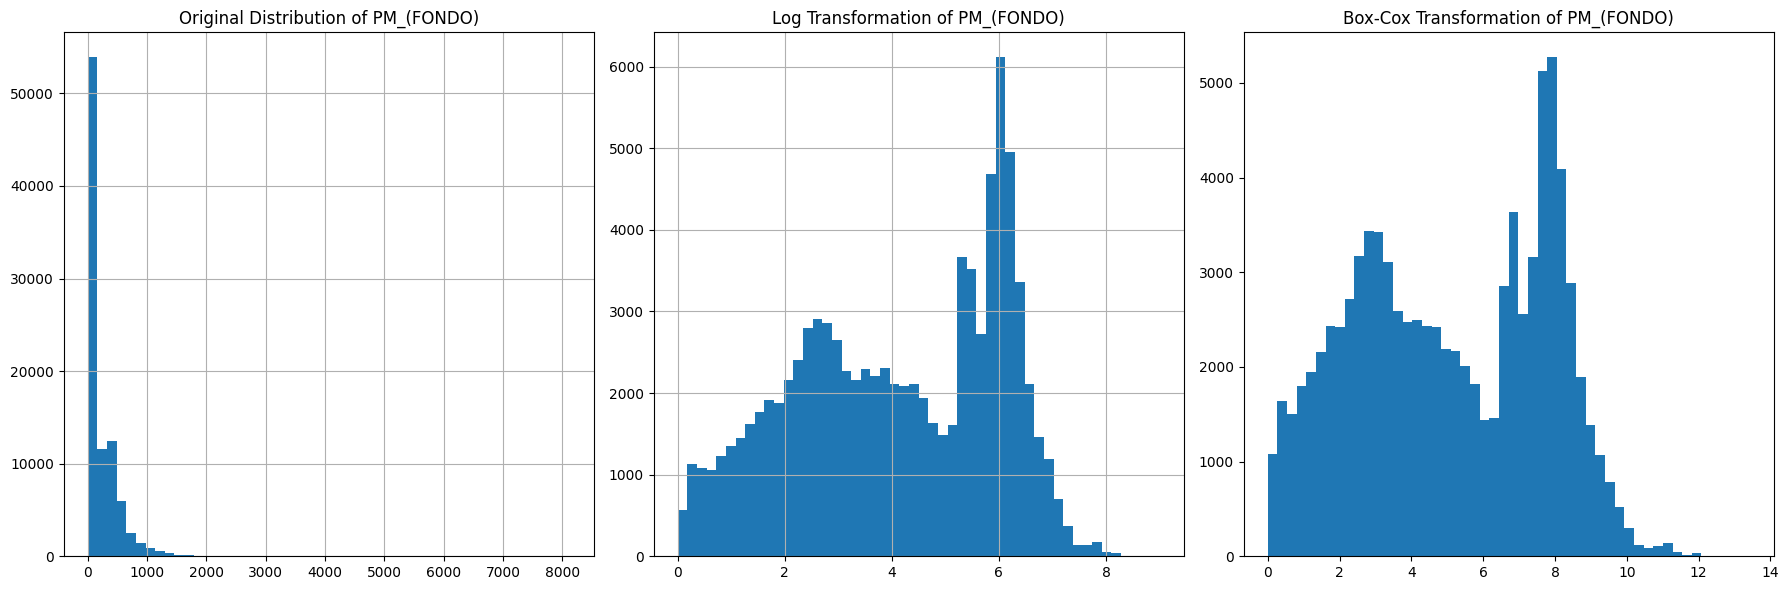

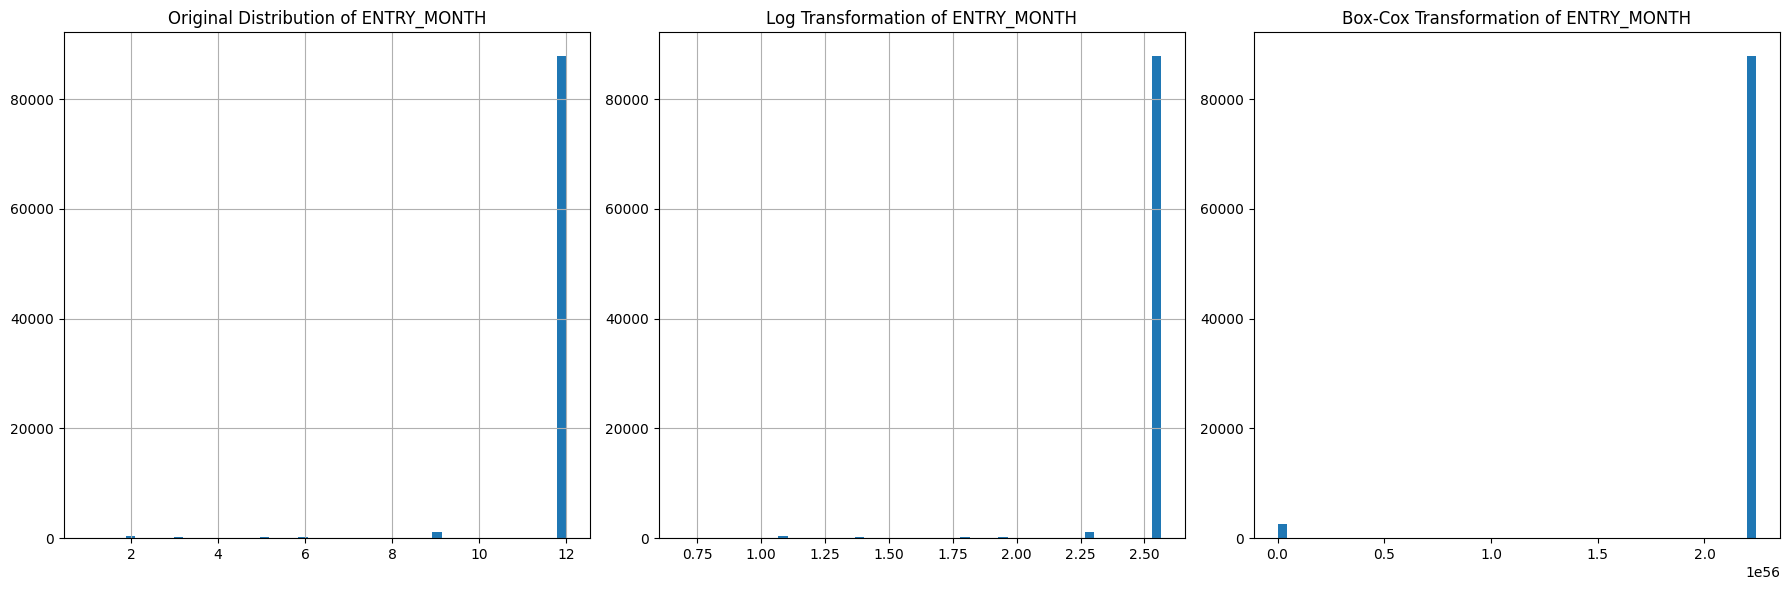

In [309]:
threshold = 0.75

# Aplicar la transformación Box-Cox solo a las variables sesgadas
X_transformed = numerical_features.copy()
for feature in skewness.index:
    if skewness[feature] > threshold or skewness[feature] < -threshold:
        # Aplicar Box-Cox, añadiendo 1 para manejar valores cero o negativos
        X_transformed[feature], _ = stats.boxcox(numerical_features[feature] + 1)
        
        # Visualización de la transformación
        plt.figure(figsize=(18, 6))
        
        # Distribución original
        plt.subplot(1, 3, 1)
        numerical_features[feature].hist(bins=50)
        plt.title(f'Original Distribution of {feature}')
        
        # Transformación Logarítmica
        plt.subplot(1, 3, 2)
        np.log1p(numerical_features[feature]).hist(bins=50)
        plt.title(f'Log Transformation of {feature}')
        
        # Transformación Box-Cox
        plt.subplot(1, 3, 3)
        plt.hist(X_transformed[feature], bins=50)
        plt.title(f'Box-Cox Transformation of {feature}')
        
        plt.tight_layout()
        plt.show()


aplicar la trasnformacion de box-cox a las dos variables 

In [310]:
# cartera.update(X_transformed)

In [311]:
cartera

,POL,EDAD,SEX,DUR_ANOS,ANTIGÜEDAD,Ano_VTO,PU,PM_(FONDO),DIFF,RESCATE,AGE_AT_ENTRY,PREM_PAYBL_M,ENTRY_MONTH,G_FUND_PC,PREM_FREQ
0,445050048961226N,59,Male,25,20,2027,900.00,1648.11,0.002,0,39,300,9,0.010920,Other
1,445050048953139K,62,Female,22,20,2024,1560.00,2879.29,0.002,0,42,264,9,0.012008,Other
2,44505004802368J,61,Female,24,20,2026,1440.00,2659.41,0.002,0,41,288,9,0.011442,Semi-Annually
3,4450500413107960F,59,Female,25,20,2027,750.00,1385.51,0.002,0,39,300,9,0.011045,Other
4,4450500411806630V,55,Female,30,20,2032,630.00,1165.46,0.002,0,35,360,9,0.009895,Cuatrimestral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90455,4450499872083989B,65,Male,5,0,2027,45.60,45.63,0.032,1,65,60,12,0.000000,Other
90456,4450499871284256B,65,Male,5,0,2027,82.17,82.23,0.032,1,65,60,12,0.000000,Other
90457,44504998Y1657846C,66,Male,5,0,2027,227.69,227.86,0.032,0,66,60,12,0.000000,Other
90458,4450499813173659H,67,Male,5,0,2027,17.03,17.04,0.032,0,67,60,12,0.000000,Other


In [312]:
cartera.to_csv('preprocesado.csv')

In [322]:
cartera.sort_values(by=['POL', 'EDAD'], inplace=True)
duplicados = cartera.copy()
# Shift para identificar cambios en el estado de rescate
duplicados['previous_rescate'] = duplicados.groupby('POL')['RESCATE'].shift(1)

# Identificar cambios de estado
duplicados['rescate_change'] = (duplicados['RESCATE'] != duplicados['previous_rescate']) & duplicados['previous_rescate'].notna()

# Filtrar para ver solo las filas donde hubo un cambio de estado
df_changes = duplicados[duplicados['rescate_change']]

# Verificar los resultados
print(df_changes[['POL', 'EDAD', 'RESCATE', 'previous_rescate']])

                     POL  EDAD  RESCATE  previous_rescate
43503  4450499810851824X    62        1               0.0
33719  4450499810872148W    57        1               0.0
18071  4450499810872148W    59        0               1.0
8873   4450499810904296L    60        1               0.0
48909  4450499810904296L    60        0               1.0
...                  ...   ...      ...               ...
82830   445050059011731D    60        1               0.0
42950   445050059011731D    61        0               1.0
61664  44505005X2865578P    60        1               0.0
4559   44505005X2865578P    61        0               1.0
89415  44505005Y3991128K    62        1               0.0

[1185 rows x 4 columns]


In [338]:
value_counts = cartera['RESCATE'].value_counts()
percentages = (value_counts / value_counts.sum()) * 100

# Combine counts and percentages into a DataFrame for better visualization
result = pd.DataFrame({'Count': value_counts, 'Percentage': percentages})

result

,Count,Percentage
RESCATE,,
0,89581,99.0283
1,879,0.9717
